# Epymorph dev log: January. 18, 2024

Author: Alexander Nez

as of git hash: 420cc7921348d0de663cceb1fb18904c21941127


In [36]:
from epymorph.data import geo_library, ipm_library, mm_library
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d, CubicSpline
from scipy.spatial.distance import squareform
from numpy.typing import DTypeLike, NDArray
from shapely.geometry import Point, Polygon
from scipy.spatial.distance import pdist
from matplotlib.gridspec import GridSpec
from IPython.core.display import SVG
from matplotlib.pyplot import xlabel
from matplotlib.patches import Circle
from shapely.geometry import Point
from scipy.optimize import minimize
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from pygris import school_districts 
from pygris import block_groups 
from pygris import geocode
from pygris import tracts
from scipy import interpolate
from census import Census
from scipy.stats import norm
import imageio.v2 as imageio 
from datetime import date
import geopandas as gpd
from numpy import size
import seaborn as sns
from PIL import Image
import pandas as pd
import numpy as np
import requests
import imageio
import random
import gzip
import time
import ast
import os
import re


In [2]:
dir = os.path.expanduser('~/Desktop/Github/EpiMoRPH-Modeling/social-determinate-of-health/scratch/Movement_model')
powerpoint = os.path.expanduser('~/Desktop/Github/EpiMoRPH-Modeling/social-determinate-of-health/scratch/powerpoints/School_movement_01-22-24')
census = Census('98a3a86a5708b65b92a50cc76d8d67280efbeb5d')

In [3]:
CentroidDType = np.dtype([('x', np.float64), ('y', np.float64)])

In [36]:
from pygris import roads


In [38]:


az_roads = roads(county= COUNTY, state= STATE)
az_roads

Using the default year of 2021
Using FIPS code '04' for input 'AZ'
Using FIPS code '013' for input 'Maricopa'


,LINEARID,FULLNAME,RTTYP,MTFCC,geometry
0,1101629368325,W Agua Caliente Rd Exn,M,S1400,"LINESTRING (-112.80257 33.25898, -112.80199 33..."
1,1101629368322,W Agua Caliente Rd Exn,M,S1400,"LINESTRING (-112.80000 33.25962, -112.79863 33..."
2,1101629368323,W Agua Caliente Rd Exn,M,S1400,"LINESTRING (-112.80898 33.25729, -112.80865 33..."
3,1101629368324,W Agua Caliente Rd Exn,M,S1400,"LINESTRING (-112.80439 33.25853, -112.80355 33..."
4,1101629373980,W Rd Exn,M,S1400,"LINESTRING (-111.85147 33.37270, -111.85123 33..."
...,...,...,...,...,...
124409,1103671721118,Serene Rdg,M,S1400,"LINESTRING (-112.42324 33.84428, -112.42325 33..."
124410,11015487625909,NaN,NaN,S1400,"LINESTRING (-112.37168 33.71658, -112.37111 33..."
124411,11015487625910,NaN,NaN,S1400,"LINESTRING (-112.37117 33.71726, -112.37122 33..."
124412,11015487021563,NaN,NaN,S1400,"LINESTRING (-112.36780 33.71306, -112.36495 33..."


In [4]:
STATE = 'AZ'
COUNTY = 'Maricopa'
YEAR = 2019

In [5]:
districts = school_districts(state = STATE, year = YEAR)
census_block_groups = block_groups(state = STATE, county = COUNTY, year = YEAR, cache=False)

Using FIPS code '04' for input 'AZ'
Using FIPS code '04' for input 'AZ'
Using FIPS code '013' for input 'Maricopa'


In [6]:
state_fips_list = census_block_groups['STATEFP'].unique()
county_fips_list = census_block_groups['COUNTYFP'].unique()

state_fips = ','.join(map(str, state_fips_list))
county_fips = ','.join(map(str, county_fips_list))

CNTY = state_fips + county_fips

districts.rename(columns={'GEOID': 'District GEOID'}, inplace=True)


# Functions


In [7]:
def random_color():
    r, g, b = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    return (r / 255.0, g / 255.0, b / 255.0, 1.0)

def haversine(centroid_1_lon: float, centroid_1_lat: float,
              centroid_2_lon: float, centroid_2_lat: float) -> np.double:
    R = 3959.87433
    dLat = np.radians(centroid_1_lat - centroid_2_lat)
    dLon = np.radians(centroid_1_lon - centroid_2_lon)
    lat1 = np.radians(centroid_1_lat)
    lat2 = np.radians(centroid_2_lat)

    a = np.sin(dLat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

def classify_school_type(low_grade, high_grade):
    if low_grade in ['PK'] and high_grade in ['PK']:
        return 'Preschool'
    if low_grade in ['KG'] and high_grade in ['KG']:
        return 'kindergarten School'
    if low_grade in ['PK', 'KG', '01', '02', '03', '04', '05'] and high_grade in ['PK', 'KG', '01', '02', '03', '04', '05']:
        return 'Elementary School'
    elif low_grade in ['06', '07', '08'] and high_grade in ['06', '07', '08']:
        return 'Middle School'
    elif low_grade in ['09', '10', '11', '12'] and high_grade in ['09', '10', '11', '12']:
        return 'High School'
    elif low_grade in ['PK', 'KG', '01', '02', '03', '04', '05'] and high_grade in ['06', '07', '08']:
        return 'Elementary/Middle School'
    elif low_grade in ['06', '07', '08'] and high_grade in ['09', '10', '11', '12']:
        return 'Middle/High School'
    else:
        return 'Elementary/Middle/High School'
    
def adjust_lightness(color, amount=0.5):
    """
    Adjust the lightness of the given color.
    `amount` > 1 will lighten the color, < 1 will darken it.
    color: RGBA tuple where each component is in the range 0 to 1
    """
    r, g, b, a = color
    r = min(r * amount, 1.0)
    g = min(g * amount, 1.0)
    b = min(b * amount, 1.0)
    return (r, g, b, a)

def distribute_students_proportionally(total_students, age_group_population):
    total_population = sum(age_group_population)
    
    if total_population == 0:
        return [0] * len(age_group_population)
    
    if total_population < total_students:
        raise ValueError("Not enough individuals to distribute students.")

    proportion = [x / total_population for x in age_group_population]
    distributed_students = [int(p * total_students) for p in proportion]

    remaining_students = total_students - sum(distributed_students)
    for i in range(len(age_group_population)):
        if age_group_population[i] > 0 and remaining_students > 0:
            distributed_students[i] += 1
            remaining_students -= 1

    return distributed_students

def read_excel_file(directory, file_path, skip_rows, dtype, usecols):
    """Reads an Excel file and returns a DataFrame based on the given parameters."""
    full_path = os.path.join(directory, file_path)
    return pd.read_excel(full_path, dtype=dtype, usecols=usecols, skiprows=skip_rows)

In [8]:
random_colors = [random_color() for _ in range(len(districts))]

districts['color'] = random_colors

districts['Centroid'] = districts['geometry'].representative_point()
districts['coords'] = districts['Centroid'].apply(lambda point: (point.x, point.y))

districts = districts.to_crs(epsg=4326)

# National Center for Education Statisitcs


In [83]:
STATE = 'AZ'

In [10]:
directory = os.path.expanduser('~/Desktop/Github/EpiMoRPH-Modeling/social-determinate-of-health/scratch/Movement_model')  
file_configs = [
    {
        "file_path": "shapefiles/EDGE_GEOCODE_PUBLICSCH_1920/EDGE_GEOCODE_PUBLICSCH_1920.xlsx",  
        "dtype": {"CNTY": object},
        "usecols": ['NCESSCH', 'CNTY', 'STREET', 'CITY', 'ZIP', 'LAT', 'LON', 'SCHOOLYEAR'],
        "skip_rows": None
    },
    {
        "file_path": f"School_movement/NCES_public_schools_{STATE}.xltx",  
        "dtype": None,
        "usecols": ['NCES School ID', 'Low Grade*', 'High Grade*', 'School Name', 'District', 'Students*',
                    'Teachers*', 'Student Teacher Ratio*'],
        "skip_rows": 14
    },
    {
        "file_path": f"School_movement/NCES_public_schools_{STATE}.xltx",  
        "dtype": None,
        "usecols": ['NCES School ID', 'Low Grade', 'High Grade', 'School Name', 'District', 'Students',
                    'Teachers', 'Student Teacher Ratio'],
        "skip_rows": 11
    }
]

schools_location_df = read_excel_file(directory, file_configs[0]['file_path'], skip_rows=file_configs[0]['skip_rows'], dtype=file_configs[0]['dtype'], usecols=file_configs[0]['usecols'])

if STATE != 'AZ':
    schools_info_df = read_excel_file(directory, file_configs[1]['file_path'], 
                                      skip_rows=file_configs[1]['skip_rows'], 
                                      dtype=file_configs[1]['dtype'], 
                                      usecols=file_configs[1]['usecols'])

    schools_info_df['school type'] = schools_info_df.apply(
        lambda row: classify_school_type(row['Low Grade*'], row['High Grade*']), axis=1)
    schools_info_df['Students*'] = pd.to_numeric(schools_info_df['Students*'], errors='coerce')
else:
    schools_info_df = read_excel_file(directory, file_configs[2]['file_path'], 
                                      skip_rows=file_configs[2]['skip_rows'], 
                                      dtype=file_configs[2]['dtype'], 
                                      usecols=file_configs[2]['usecols'])

    schools_info_df['school type'] = schools_info_df.apply(
        lambda row: classify_school_type(row['Low Grade'], row['High Grade']), axis=1)
    schools_info_df['Students'] = pd.to_numeric(schools_info_df['Students'], errors='coerce')

NCES_public_schools_df = pd.merge(schools_info_df, schools_location_df, left_on='NCES School ID', right_on='NCESSCH')

NCES_public_schools_df = NCES_public_schools_df[NCES_public_schools_df['CNTY'] == CNTY]

NCES_public_schools_df.drop(columns=['NCESSCH'], inplace=True)


NCES_public_schools_df

,NCES School ID,Low Grade,High Grade,School Name,District,Students,Teachers,Student Teacher Ratio,school type,STREET,CITY,ZIP,CNTY,LAT,LON,SCHOOLYEAR
3,40010601892,09,12,AAEC - Paradise Valley,Arizona Agribusiness & Equine Center Inc. (4331),316.0,–,†,High School,3775 E UNION HILLS DR,PHOENIX,85050,04013,33.654305,-112.001380,2019-2020
4,40041701588,09,12,AAEC - SMCC Campus,Arizona Agribusiness & Equine Center Inc. (85816),486.0,–,†,High School,7050 S 24TH ST BLDG AAEC,PHOENIX,85042,04013,33.381603,-112.033968,2019-2020
6,40906000652,PK,08,Abraham Lincoln Traditional School,Washington Elementary School District (4260),544.0,33.80000,16.0900000,Elementary/Middle School,10444 N 39TH AVE,PHOENIX,85051,04013,33.581300,-112.144000,2019-2020
7,40906000915,KG,06,Acacia Elementary School,Washington Elementary School District (4260),788.0,41.90000,18.8100000,Elementary/Middle School,3021 W EVANS DR,PHOENIX,85053,04013,33.616200,-112.123800,2019-2020
14,40089103676,KG,08,Academy of Math and Science Avondale,Academy of Mathematics and Science South Inc. ...,990.0,–,†,Elementary/Middle School,10649 W Buckeye Rd,Phoenix,85353,04013,33.434499,-112.286551,2019-2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2270,40831000789,PK,05,Wood School,Tempe School District (4258),516.0,36.66000,14.0800000,Elementary School,727 W CORNELL DR,TEMPE,85283,04013,33.371900,-111.951300,2019-2020
2274,40757000666,PK,06,Yavapai Elementary School,Scottsdale Unified District (4240),387.0,25.60000,15.1200000,Elementary/Middle School,701 N MILLER RD,SCOTTSDALE,85257,04013,33.455500,-111.917100,2019-2020
2278,40141002786,09,12,Youngker High School,Buckeye Union High School District (4284),2099.0,85.00000,24.6900000,High School,3000 S APACHE RD,BUCKEYE,85326,04013,33.418500,-112.574800,2019-2020
2284,40497002280,PK,06,Zaharis Elementary,Mesa Unified District (4235),769.0,45.70000,16.8300000,Elementary/Middle School,9410 E MCKELLIPS RD,MESA,85207,04013,33.455000,-111.628000,2019-2020


In [11]:
geometry = [Point(xy) for xy in zip(NCES_public_schools_df['LON'], NCES_public_schools_df['LAT'])]
gdf_public_schools = gpd.GeoDataFrame(NCES_public_schools_df, geometry=geometry)
gdf_public_schools.set_crs(epsg=4269, inplace=True)

gdf_public_schools.head()

,NCES School ID,Low Grade,High Grade,School Name,District,Students,Teachers,Student Teacher Ratio,school type,STREET,CITY,ZIP,CNTY,LAT,LON,SCHOOLYEAR,geometry
3,40010601892,09,12,AAEC - Paradise Valley,Arizona Agribusiness & Equine Center Inc. (4331),316.0,–,†,High School,3775 E UNION HILLS DR,PHOENIX,85050,04013,33.654305,-112.001380,2019-2020,POINT (-112.00138 33.65431)
4,40041701588,09,12,AAEC - SMCC Campus,Arizona Agribusiness & Equine Center Inc. (85816),486.0,–,†,High School,7050 S 24TH ST BLDG AAEC,PHOENIX,85042,04013,33.381603,-112.033968,2019-2020,POINT (-112.03397 33.38160)
6,40906000652,PK,08,Abraham Lincoln Traditional School,Washington Elementary School District (4260),544.0,33.80000,16.0900000,Elementary/Middle School,10444 N 39TH AVE,PHOENIX,85051,04013,33.581300,-112.144000,2019-2020,POINT (-112.14400 33.58130)
7,40906000915,KG,06,Acacia Elementary School,Washington Elementary School District (4260),788.0,41.90000,18.8100000,Elementary/Middle School,3021 W EVANS DR,PHOENIX,85053,04013,33.616200,-112.123800,2019-2020,POINT (-112.12380 33.61620)
14,40089103676,KG,08,Academy of Math and Science Avondale,Academy of Mathematics and Science South Inc. ...,990.0,–,†,Elementary/Middle School,10649 W Buckeye Rd,Phoenix,85353,04013,33.434499,-112.286551,2019-2020,POINT (-112.28655 33.43450)


In [12]:
crs_to_use = 'EPSG:4269'  # Example CRS, choose as per your requirement
districts = districts.to_crs(crs_to_use)
census_block_groups = census_block_groups.to_crs(crs_to_use)
gdf_public_schools = gdf_public_schools.to_crs(crs_to_use)

# Perform overlays
intersection_area_cbg = gpd.overlay(census_block_groups, districts, how='intersection')

# Perform spatial joins with the predicate parameter
schools_in_intersection_cbg = gpd.sjoin(gdf_public_schools, intersection_area_cbg, how='inner', predicate='intersects')
schools_in_intersection_cbg

/Users/alexandernez/Desktop/Github/Epymorph_vignettes/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1813: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union
/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_1496/55080538.py:7: UserWarning: `keep_geom_type=True` in overlay resulted in 534 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersection_area_cbg = gpd.overlay(census_block_groups, districts, how='intersection')


,NCES School ID,Low Grade,High Grade,School Name,District,Students,Teachers,Student Teacher Ratio,school type,STREET,...,MTFCC_2,SDTYP,FUNCSTAT_2,ALAND_2,AWATER_2,INTPTLAT_2,INTPTLON_2,color,Centroid,coords
3,40010601892,09,12,AAEC - Paradise Valley,Arizona Agribusiness & Equine Center Inc. (4331),316.0,–,†,High School,3775 E UNION HILLS DR,...,G5420,None,E,253218847,500050,+33.6534512,-111.9799825,"(1.0, 0.3607843137254902, 0.5647058823529412, ...",POINT (-111.97802 33.64014),"(-111.97801767944645, 33.6401435)"
18,40089103604,KG,08,Academy of Math and Science Peoria Advanced,Academy of Mathematics and Science South Inc. ...,791.0,–,†,Elementary/Middle School,7785 W PEORIA AVE,...,G5420,None,E,354992394,2916252,+33.7218339,-112.2916224,"(0.11764705882352941, 0.25882352941176473, 0.3...",POINT (-112.30765 33.72253),"(-112.30765139497319, 33.722534499999995)"
24,40027601841,09,12,Academy with Community Partners,Academy with Community Partners Inc (79213),171.0,–,†,High School,433 N HALL,...,G5420,None,E,480440807,9999397,+33.4544563,-111.7236690,"(0.20784313725490197, 0.21176470588235294, 0.6...",POINT (-111.72765 33.45110),"(-111.72764817425373, 33.4510955)"
25,40012101581,09,12,Accelerated Learning Center,Accelerated Learning Center Inc. (4297),153.0,–,†,High School,4105 E SHEA BLVD,...,G5420,None,E,286607030,1303711,+33.5816291,-111.8867550,"(0.0784313725490196, 0.3411764705882353, 0.713...",POINT (-111.88288 33.57471),"(-111.88287981295731, 33.5747075)"
29,40497000378,PK,06,Adams Elementary School,Mesa Unified District (4235),629.0,37.40000,16.8200000,Elementary/Middle School,738 S LONGMORE,...,G5420,None,E,480440807,9999397,+33.4544563,-111.7236690,"(0.20784313725490197, 0.21176470588235294, 0.6...",POINT (-111.72765 33.45110),"(-111.72764817425373, 33.4510955)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,40497001667,PK,06,Wilson Elementary School,Mesa Unified District (4235),465.0,31.70000,14.6700000,Elementary/Middle School,5619 E GLADE AVE,...,G5420,None,E,480440807,9999397,+33.4544563,-111.7236690,"(0.20784313725490197, 0.21176470588235294, 0.6...",POINT (-111.72765 33.45110),"(-111.72764817425373, 33.4510955)"
2268,40717002808,KG,05,Winters Well Elementary School,Saddle Mountain Unified School District (4254),578.0,29.50000,19.5900000,Elementary School,35220 W BUCKEYE RD,...,G5420,None,E,1422535338,137597,+33.5467843,-112.8634044,"(0.12549019607843137, 0.8980392156862745, 0.50...",POINT (-112.76884 33.50926),"(-112.7688428443478, 33.509262)"
2274,40757000666,PK,06,Yavapai Elementary School,Scottsdale Unified District (4240),387.0,25.60000,15.1200000,Elementary/Middle School,701 N MILLER RD,...,G5420,None,E,286607030,1303711,+33.5816291,-111.8867550,"(0.0784313725490196, 0.3411764705882353, 0.713...",POINT (-111.88288 33.57471),"(-111.88287981295731, 33.5747075)"
2284,40497002280,PK,06,Zaharis Elementary,Mesa Unified District (4235),769.0,45.70000,16.8300000,Elementary/Middle School,9410 E MCKELLIPS RD,...,G5420,None,E,480440807,9999397,+33.4544563,-111.7236690,"(0.20784313725490197, 0.21176470588235294, 0.6...",POINT (-111.72765 33.45110),"(-111.72764817425373, 33.4510955)"


In [13]:
School_path = os.path.expanduser('~/Desktop/Github/Epymorph_vignettes/scratch/Measles_school_coverage.csv')
Measles_school_coverage = pd.read_csv(School_path, dtype={'GEOID': str})
Measles_school_coverage

,SCHOOL NAME,ADDRESS,CITY,COUNTY,ZIP,SCHOOL NURSE,SCHOOL NURSE TYPE,ENROLLED,% IMMUNE MMR,% EXEMPT MMR,% COMPLIANCE MMR,SCHOOL TYPE,key,School_Coords_Lat,School_Coords_Lon,GEOID
0,1ST ACADEMY PRESCHOOL & CHILD CARE,1133 S DOBSON RD,MESA,MARICOPA,85202,NO,NaN,55,1.000000,0.000000,1.000000,NaN,1133SDOBSONRD,33.394645,-111.874537,040134221033
1,5TH PLACE COMMUNITY CHILD CARE,306 W 5TH PL,MESA,MARICOPA,85201,NO,NaN,<20,1.000000,0.000000,1.000000,NaN,306W5THPL,33.425211,-111.838970,040134210012
2,91ST PSALM CHRISTIAN SCHOOL,2020 EAST BASELINE ROAD,PHOENIX,MARICOPA,85042,NO,NaN,<20,0.812500,0.187500,1.000000,NaN,2020EASTBASELINEROAD,33.377931,-112.038373,040131163003
3,A CHILD''S PLACE AT THE RANCHES LLC,3636 S ATHERTON BLVD,GILBERT,MARICOPA,85297,NO,NaN,45,0.955556,0.022222,0.977778,NaN,3636SATHERTONBLVD,33.284575,-111.716741,040138157002
4,"A GREAT BEGINNING, INC.",13380 W VAN BUREN ST,GOODYEAR,MARICOPA,85338,NO,NaN,74,0.972973,0.027027,1.000000,NaN,13380WVANBURENST,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,POMEROY ELEMENTARY SCHOOL,1507 W SHAWNEE DR,CHANDLER,MARICOPA,85224,YES,RN,67,1.000000,0.000000,1.000000,PUBLIC,1507WSHAWNEEDR,33.344243,-111.867736,040134222101
2326,HIGHLAND ELEMENTARY SCHOOL,3042 E ADOBE ST,MESA,MARICOPA,85213,YES,RN,90,0.966667,0.033333,1.000000,PUBLIC,3042EADOBEST,33.430043,-111.765115,040134207043
2327,CRISMON ELEMENTARY SCHOOL,825 W MEDINA AVE,MESA,MARICOPA,85210,YES,RN,60,0.950000,0.050000,1.000000,PUBLIC,825WMEDINAAVE,33.371443,-111.853396,040134222162
2328,ST. LOUIS THE KING PRE-KINDERGARTEN AND EXTEND...,4331 W MARYLAND AVE,GLENDALE,MARICOPA,85301,NO,NaN,24,0.958333,0.000000,1.000000,PRIVATE,4331WMARYLANDAVE,33.531130,-112.153975,040130930023


In [14]:
geometry = [Point(xy) for xy in zip(Measles_school_coverage['School_Coords_Lon'], Measles_school_coverage['School_Coords_Lat'])]

# Create a GeoDataFrame using the original DataFrame and the geometry list
gdf = gpd.GeoDataFrame(Measles_school_coverage, geometry=geometry)

# Set the coordinate reference system (CRS) to EPSG:4269
gdf.set_crs(epsg=4269, inplace=True)
gdf

,SCHOOL NAME,ADDRESS,CITY,COUNTY,ZIP,SCHOOL NURSE,SCHOOL NURSE TYPE,ENROLLED,% IMMUNE MMR,% EXEMPT MMR,% COMPLIANCE MMR,SCHOOL TYPE,key,School_Coords_Lat,School_Coords_Lon,GEOID,geometry
0,1ST ACADEMY PRESCHOOL & CHILD CARE,1133 S DOBSON RD,MESA,MARICOPA,85202,NO,NaN,55,1.000000,0.000000,1.000000,NaN,1133SDOBSONRD,33.394645,-111.874537,040134221033,POINT (-111.87454 33.39465)
1,5TH PLACE COMMUNITY CHILD CARE,306 W 5TH PL,MESA,MARICOPA,85201,NO,NaN,<20,1.000000,0.000000,1.000000,NaN,306W5THPL,33.425211,-111.838970,040134210012,POINT (-111.83897 33.42521)
2,91ST PSALM CHRISTIAN SCHOOL,2020 EAST BASELINE ROAD,PHOENIX,MARICOPA,85042,NO,NaN,<20,0.812500,0.187500,1.000000,NaN,2020EASTBASELINEROAD,33.377931,-112.038373,040131163003,POINT (-112.03837 33.37793)
3,A CHILD''S PLACE AT THE RANCHES LLC,3636 S ATHERTON BLVD,GILBERT,MARICOPA,85297,NO,NaN,45,0.955556,0.022222,0.977778,NaN,3636SATHERTONBLVD,33.284575,-111.716741,040138157002,POINT (-111.71674 33.28457)
4,"A GREAT BEGINNING, INC.",13380 W VAN BUREN ST,GOODYEAR,MARICOPA,85338,NO,NaN,74,0.972973,0.027027,1.000000,NaN,13380WVANBURENST,NaN,NaN,NaN,POINT EMPTY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,POMEROY ELEMENTARY SCHOOL,1507 W SHAWNEE DR,CHANDLER,MARICOPA,85224,YES,RN,67,1.000000,0.000000,1.000000,PUBLIC,1507WSHAWNEEDR,33.344243,-111.867736,040134222101,POINT (-111.86774 33.34424)
2326,HIGHLAND ELEMENTARY SCHOOL,3042 E ADOBE ST,MESA,MARICOPA,85213,YES,RN,90,0.966667,0.033333,1.000000,PUBLIC,3042EADOBEST,33.430043,-111.765115,040134207043,POINT (-111.76512 33.43004)
2327,CRISMON ELEMENTARY SCHOOL,825 W MEDINA AVE,MESA,MARICOPA,85210,YES,RN,60,0.950000,0.050000,1.000000,PUBLIC,825WMEDINAAVE,33.371443,-111.853396,040134222162,POINT (-111.85340 33.37144)
2328,ST. LOUIS THE KING PRE-KINDERGARTEN AND EXTEND...,4331 W MARYLAND AVE,GLENDALE,MARICOPA,85301,NO,NaN,24,0.958333,0.000000,1.000000,PRIVATE,4331WMARYLANDAVE,33.531130,-112.153975,040130930023,POINT (-112.15397 33.53113)


In [15]:
gdf_merged = gdf.merge(census_block_groups, on='GEOID', how='left')

gdf_merged

,SCHOOL NAME,ADDRESS,CITY,COUNTY,ZIP,SCHOOL NURSE,SCHOOL NURSE TYPE,ENROLLED,% IMMUNE MMR,% EXEMPT MMR,...,TRACTCE,BLKGRPCE,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry_y
0,1ST ACADEMY PRESCHOOL & CHILD CARE,1133 S DOBSON RD,MESA,MARICOPA,85202,NO,NaN,55,1.000000,0.000000,...,422103,3,Block Group 3,G5030,S,244557.0,0.0,+33.3957470,-111.8723281,"POLYGON ((-111.87461 33.39335, -111.87461 33.3..."
1,5TH PLACE COMMUNITY CHILD CARE,306 W 5TH PL,MESA,MARICOPA,85201,NO,NaN,<20,1.000000,0.000000,...,421001,2,Block Group 2,G5030,S,637864.0,0.0,+33.4295977,-111.8377747,"POLYGON ((-111.83996 33.42603, -111.83995 33.4..."
2,91ST PSALM CHRISTIAN SCHOOL,2020 EAST BASELINE ROAD,PHOENIX,MARICOPA,85042,NO,NaN,<20,0.812500,0.187500,...,116300,3,Block Group 3,G5030,S,1367903.0,0.0,+33.3816469,-112.0385041,"POLYGON ((-112.04735 33.37786, -112.04733 33.3..."
3,A CHILD''S PLACE AT THE RANCHES LLC,3636 S ATHERTON BLVD,GILBERT,MARICOPA,85297,NO,NaN,45,0.955556,0.022222,...,815700,2,Block Group 2,G5030,S,1139070.0,0.0,+33.2854907,-111.7166323,"POLYGON ((-111.72094 33.29245, -111.71950 33.2..."
4,"A GREAT BEGINNING, INC.",13380 W VAN BUREN ST,GOODYEAR,MARICOPA,85338,NO,NaN,74,0.972973,0.027027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,POMEROY ELEMENTARY SCHOOL,1507 W SHAWNEE DR,CHANDLER,MARICOPA,85224,YES,RN,67,1.000000,0.000000,...,422210,1,Block Group 1,G5030,S,1082956.0,0.0,+33.3413141,-111.8725615,"POLYGON ((-111.87647 33.34954, -111.87420 33.3..."
2326,HIGHLAND ELEMENTARY SCHOOL,3042 E ADOBE ST,MESA,MARICOPA,85213,YES,RN,90,0.966667,0.033333,...,420704,3,Block Group 3,G5030,S,904003.0,0.0,+33.4310444,-111.7666490,"POLYGON ((-111.77098 33.42769, -111.77098 33.4..."
2327,CRISMON ELEMENTARY SCHOOL,825 W MEDINA AVE,MESA,MARICOPA,85210,YES,RN,60,0.950000,0.050000,...,422216,2,Block Group 2,G5030,S,584969.0,0.0,+33.3679120,-111.8553358,"POLYGON ((-111.85942 33.37149, -111.85910 33.3..."
2328,ST. LOUIS THE KING PRE-KINDERGARTEN AND EXTEND...,4331 W MARYLAND AVE,GLENDALE,MARICOPA,85301,NO,NaN,24,0.958333,0.000000,...,093002,3,Block Group 3,G5030,S,442583.0,0.0,+33.5294921,-112.1582616,"POLYGON ((-112.16434 33.52767, -112.16434 33.5..."


In [27]:
gdf_merged.plot(column='% IMMUNE MMR', ax=ax, legend=True,
                        legend_kwds={'label': '% IMMUNE MMR', 'orientation': "vertical"},
                        markersize=0.5,linewidth=0.5, cmap='cividis')

NameError: name 'ax' is not defined

/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_1496/2213412806.py:8: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf_merged.plot(ax=ax, linewidth=0.1, edgecolor='black', color='blue', markersize=5, column='% IMMUNE MMR', legend=True,


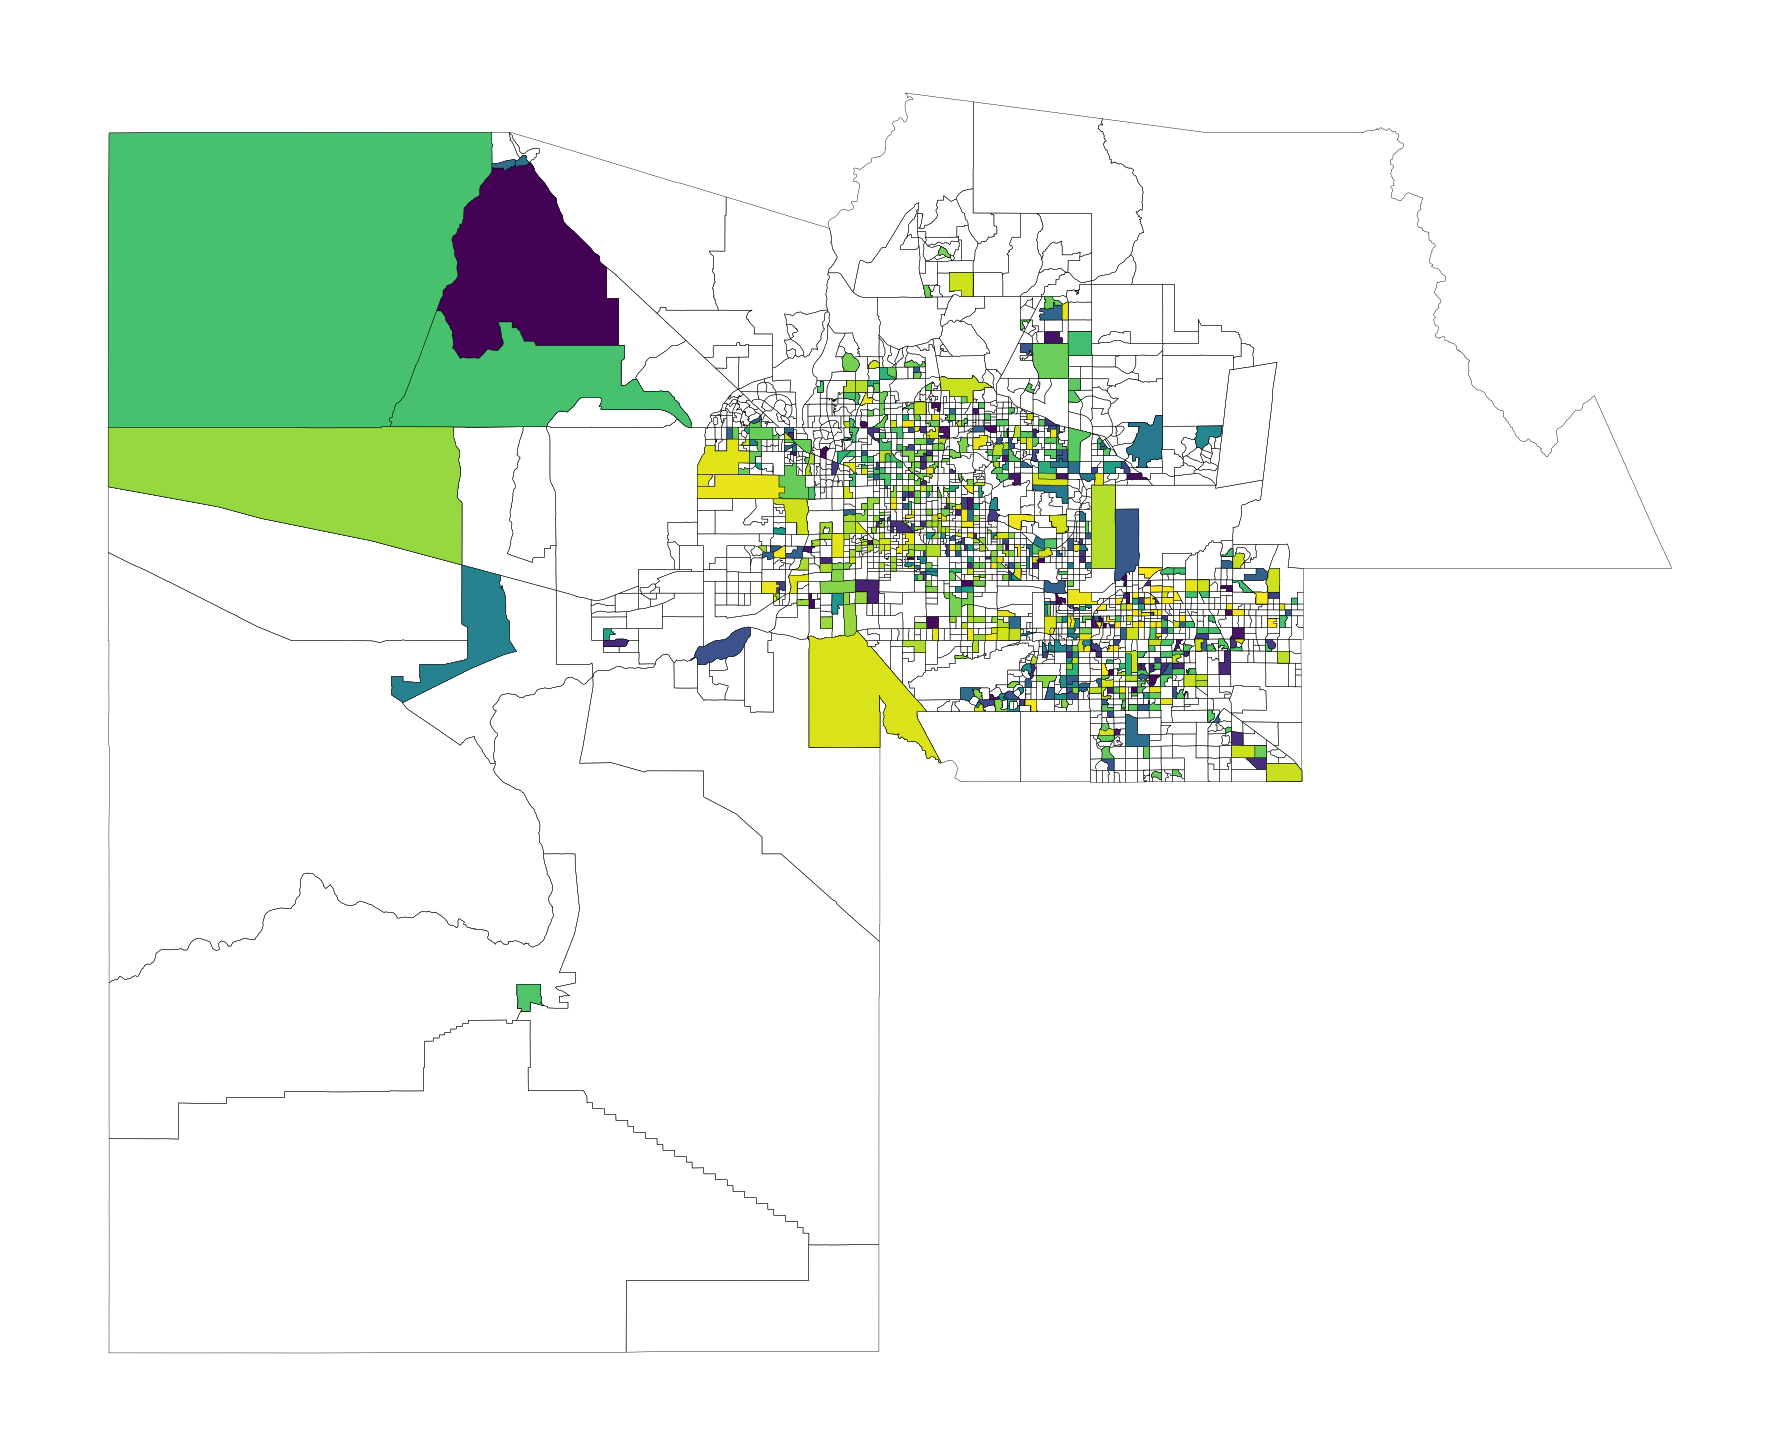

In [16]:
gdf_merged = gpd.GeoDataFrame(gdf_merged, geometry='geometry_y')

gdf_merged.crs = "EPSG:4326"

fig, ax = plt.subplots(figsize=(10, 6), dpi = 300)
census_block_groups.plot(linewidth=0.1, ax=ax, edgecolor='black', color='none')

gdf_merged.plot(ax=ax, linewidth=0.1, edgecolor='black', color='blue', markersize=5, column='% IMMUNE MMR', legend=True,
                legend_kwds={'label': '% IMMUNE MMR Weighted', 'orientation': "vertical"}, cmap='viridis' 
                )

ax.axis('off') 
plt.show()

In [17]:
gdf_merged['SCHOOL TYPE'].fillna('CHILD CARE', inplace=True)

public_schools = gdf_merged[gdf_merged['SCHOOL TYPE'] == 'PUBLIC']
charter_schools = gdf_merged[gdf_merged['SCHOOL TYPE'] == 'CHARTER']
private_schools = gdf_merged[gdf_merged['SCHOOL TYPE'] == 'PRIVATE']
child_care_schools = gdf_merged[gdf_merged['SCHOOL TYPE'] == 'CHILD CARE']


/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_1496/1350348037.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf_merged['SCHOOL TYPE'].fillna('CHILD CARE', inplace=True)


/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_1496/3718322428.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SCHOOL TYPE', y='% IMMUNE MMR', data=combined_data, palette="muted")


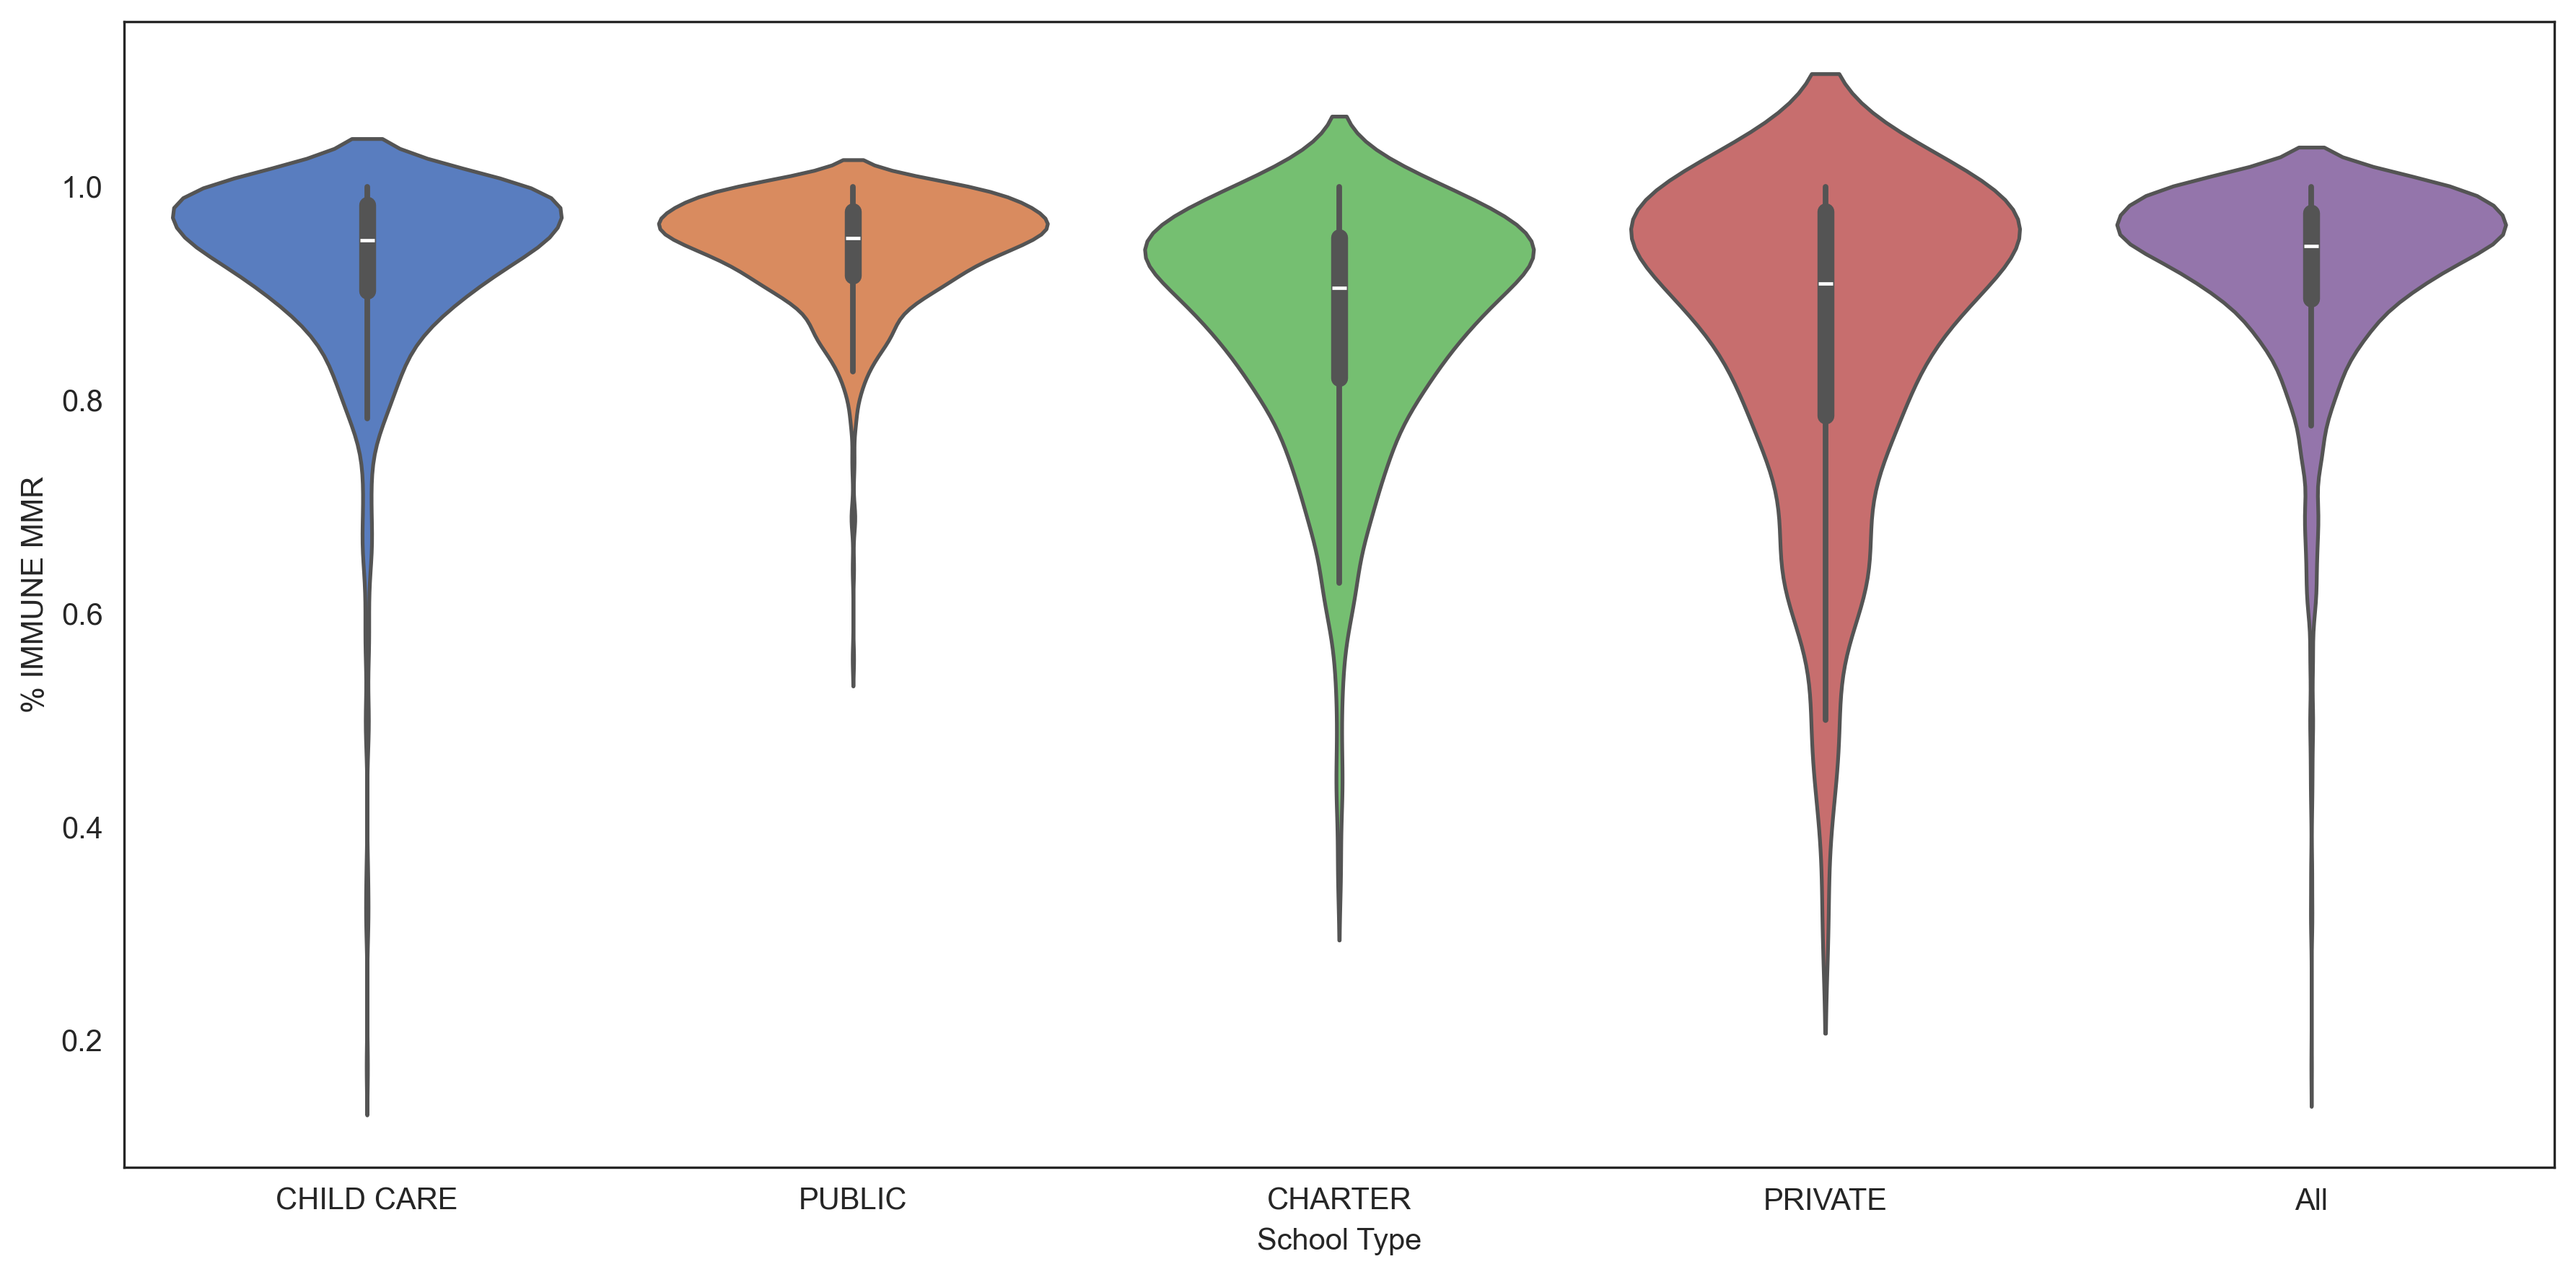

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# First, create a copy of the dataset with a new 'SCHOOL TYPE' labeled 'All'
all_schools = gdf_merged.copy()
all_schools['SCHOOL TYPE'] = 'All'

# Combine the original and the new dataset
combined_data = pd.concat([gdf_merged, all_schools])
sns.set_style("white")

# Now, plot the combined dataset
plt.figure(figsize=(12, 6), dpi = 300)
sns.violinplot(x='SCHOOL TYPE', y='% IMMUNE MMR', data=combined_data, palette="muted")

# Enhance the plot
plt.xlabel('School Type')
plt.ylabel('% IMMUNE MMR')

plt.tight_layout()
plt.show()



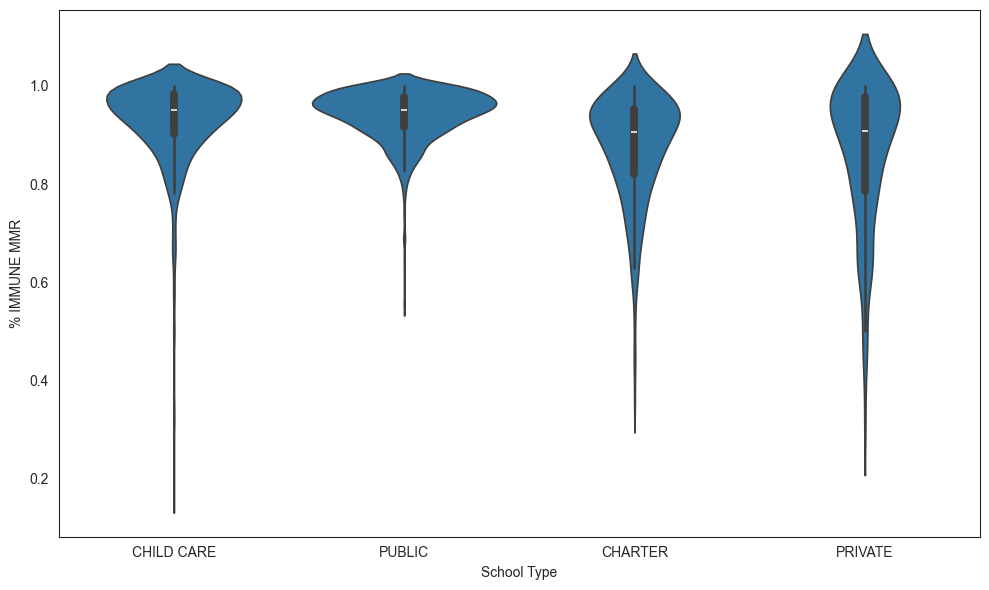

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")

plt.figure(figsize=(10, 6))
sns.violinplot(x='SCHOOL TYPE', y='% IMMUNE MMR', data=gdf_merged)

plt.xlabel('School Type')
plt.ylabel('% IMMUNE MMR')

plt.tight_layout()
plt.show()


NameError: name 'percentage_dissolved_gdf' is not defined

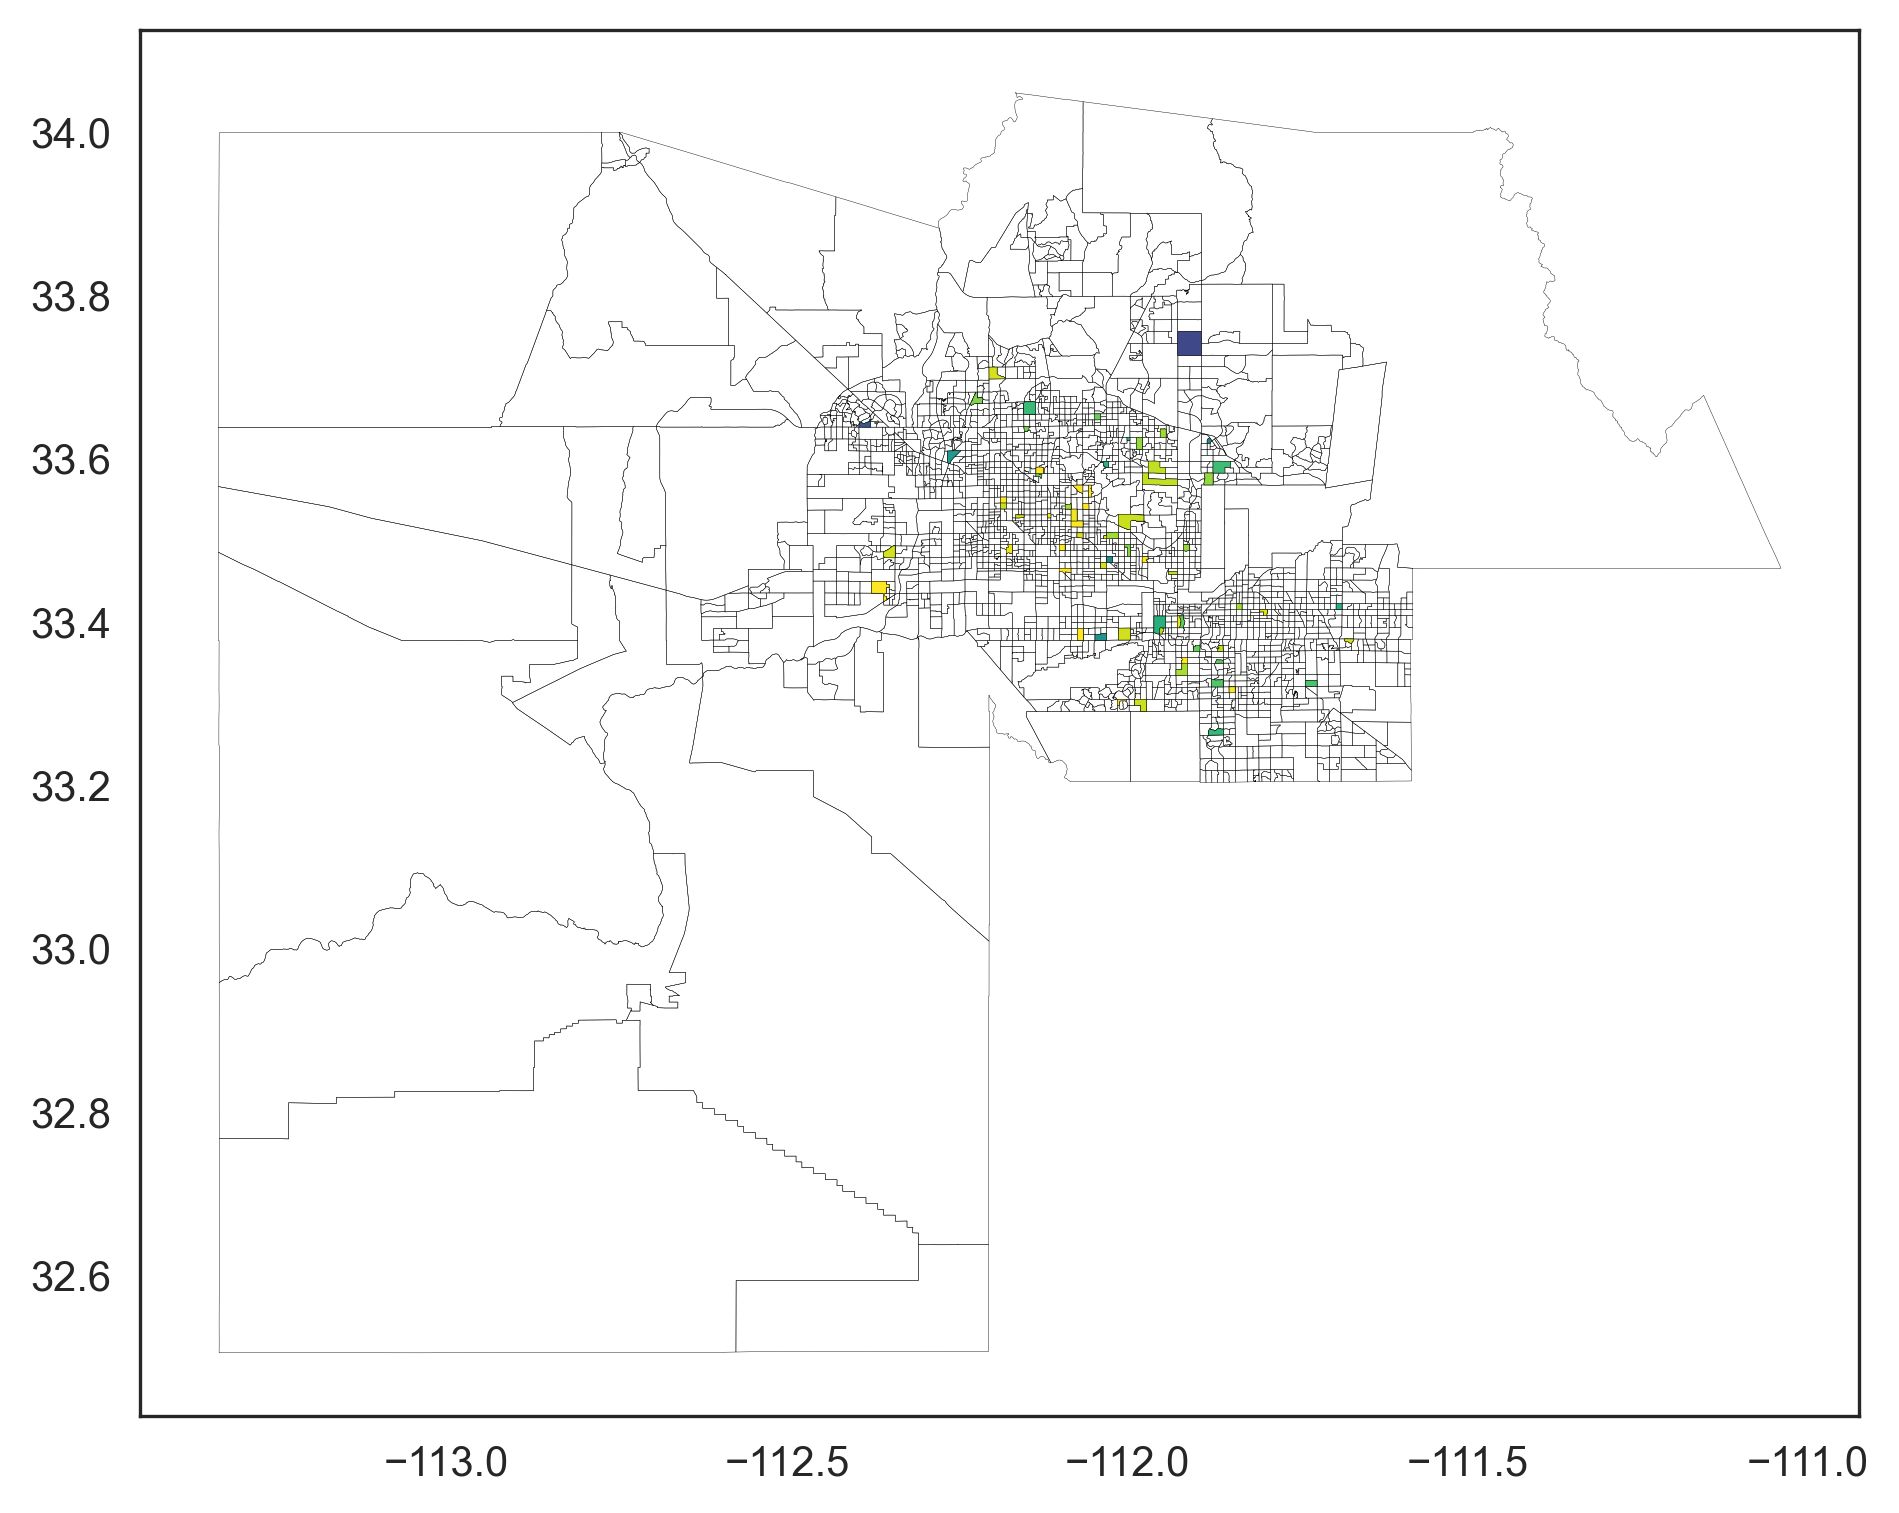

In [20]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

census_block_groups.plot(linewidth=0.1, ax=ax, edgecolor='black', color='none')

plot = private_schools.plot(ax=ax, linewidth=0.1, edgecolor='black', markersize=5, column='% IMMUNE MMR',
                       cmap='viridis', legend=False)  
percentage_dissolved_gdf.plot(linewidth=0.8, ax=ax, edgecolor='black', color='none')

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=gdf_merged['% IMMUNE MMR'].min(), vmax=gdf_merged['% IMMUNE MMR'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('% IMMUNE MMR Weighted')

ax.axis('off')
plt.show()


In [21]:
Measles_school_coverage['% IMMUNE MMR'] = pd.to_numeric(Measles_school_coverage['% IMMUNE MMR'], errors='coerce')
Measles_school_coverage['ENROLLED'] = pd.to_numeric(Measles_school_coverage['ENROLLED'], errors='coerce')

Measles_school_coverage['Weighted_IMMUNE'] = Measles_school_coverage['% IMMUNE MMR'] * Measles_school_coverage['ENROLLED']

weighted_sum = Measles_school_coverage.groupby('GEOID')['Weighted_IMMUNE'].sum()
total_students = Measles_school_coverage.groupby('GEOID')['ENROLLED'].sum()
weighted_avg = weighted_sum / total_students
weighted_avg_df = weighted_avg.reset_index(name='% IMMUNE MMR Weighted')

census_block_groups_merged = pd.merge(census_block_groups, weighted_avg_df, on='GEOID', how='left')
census_block_groups_merged

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,% IMMUNE MMR Weighted
0,04,013,421702,3,040134217023,Block Group 3,G5030,S,310375,0,+33.4123043,-111.7788867,"POLYGON ((-111.78406 33.41540, -111.78259 33.4...",NaN
1,04,013,040531,2,040130405312,Block Group 2,G5030,S,616061,0,+33.6422660,-112.3722104,"POLYGON ((-112.37679 33.64389, -112.37673 33.6...",NaN
2,04,013,092312,1,040130923121,Block Group 1,G5030,S,295623,0,+33.5654583,-112.1989360,"POLYGON ((-112.20294 33.56672, -112.20293 33.5...",NaN
3,04,013,092721,1,040130927211,Block Group 1,G5030,S,1108648,0,+33.5408739,-112.2472748,"POLYGON ((-112.25507 33.53763, -112.25507 33.5...",NaN
4,04,013,093104,1,040130931041,Block Group 1,G5030,S,168697,0,+33.5113085,-112.1797305,"POLYGON ((-112.18194 33.50955, -112.18193 33.5...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2500,04,013,811900,2,040138119002,Block Group 2,G5030,S,771839,0,+33.2801026,-111.8638617,"POLYGON ((-111.87111 33.28352, -111.87031 33.2...",NaN
2501,04,013,812000,1,040138120001,Block Group 1,G5030,S,1279036,0,+33.2802159,-111.8501034,"POLYGON ((-111.85867 33.28374, -111.85848 33.2...",NaN
2502,04,013,812000,2,040138120002,Block Group 2,G5030,S,1360898,0,+33.2876864,-111.8502128,"POLYGON ((-111.85885 33.29153, -111.85853 33.2...",NaN
2503,04,013,523002,3,040135230023,Block Group 3,G5030,S,666349,0,+33.3097028,-111.8546715,"POLYGON ((-111.85910 33.30737, -111.85908 33.3...",NaN


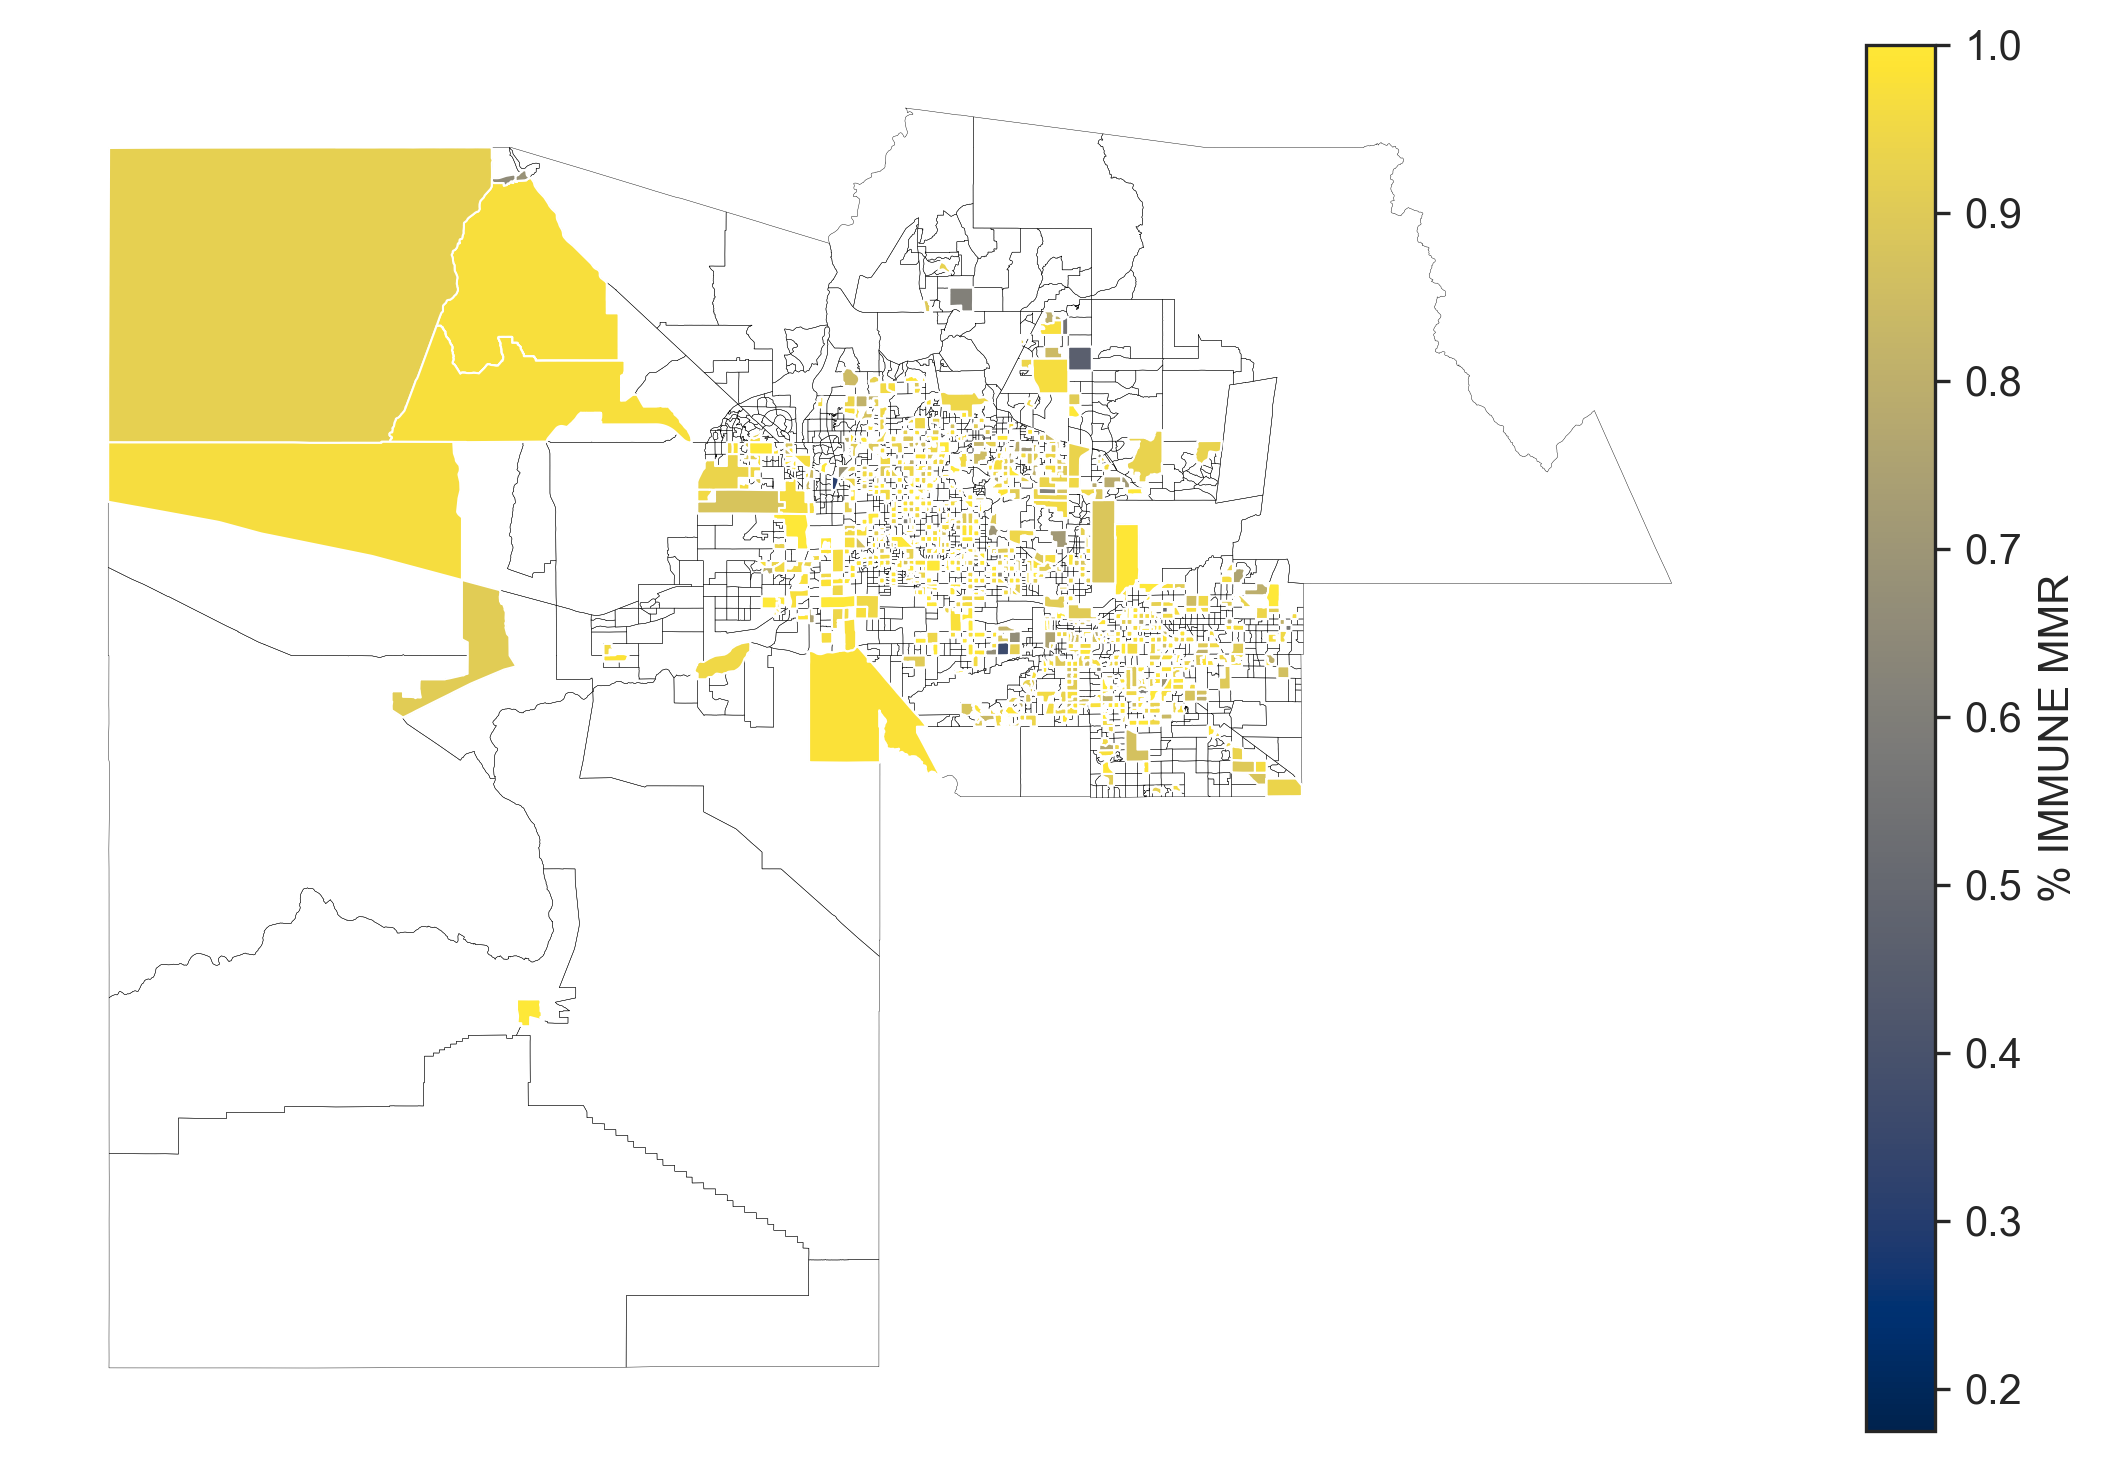

In [22]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

census_block_groups.plot(linewidth=0.1, ax=ax, edgecolor='black', color='none')

gdf_merged.plot(column='% IMMUNE MMR', ax=ax, legend=True,
                        legend_kwds={'label': '% IMMUNE MMR', 'orientation': "vertical"},
                        markersize=0.5,linewidth=0.5, cmap='cividis')

ax.axis('off') 
plt.show()

In [23]:
Measles_school_coverage_NCES = pd.merge(Measles_school_coverage, census_block_groups, on='GEOID', how='inner')
Measles_school_coverage_NCES

,SCHOOL NAME,ADDRESS,CITY,COUNTY,ZIP,SCHOOL NURSE,SCHOOL NURSE TYPE,ENROLLED,% IMMUNE MMR,% EXEMPT MMR,...,TRACTCE,BLKGRPCE,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,1ST ACADEMY PRESCHOOL & CHILD CARE,1133 S DOBSON RD,MESA,MARICOPA,85202,NO,NaN,55.0,1.000000,0.000000,...,422103,3,Block Group 3,G5030,S,244557,0,+33.3957470,-111.8723281,"POLYGON ((-111.87461 33.39335, -111.87461 33.3..."
1,5TH PLACE COMMUNITY CHILD CARE,306 W 5TH PL,MESA,MARICOPA,85201,NO,NaN,NaN,1.000000,0.000000,...,421001,2,Block Group 2,G5030,S,637864,0,+33.4295977,-111.8377747,"POLYGON ((-111.83996 33.42603, -111.83995 33.4..."
2,91ST PSALM CHRISTIAN SCHOOL,2020 EAST BASELINE ROAD,PHOENIX,MARICOPA,85042,NO,NaN,NaN,0.812500,0.187500,...,116300,3,Block Group 3,G5030,S,1367903,0,+33.3816469,-112.0385041,"POLYGON ((-112.04735 33.37786, -112.04733 33.3..."
3,A CHILD''S PLACE AT THE RANCHES LLC,3636 S ATHERTON BLVD,GILBERT,MARICOPA,85297,NO,NaN,45.0,0.955556,0.022222,...,815700,2,Block Group 2,G5030,S,1139070,0,+33.2854907,-111.7166323,"POLYGON ((-111.72094 33.29245, -111.71950 33.2..."
4,A KIDDIE''S KINGDOM,2318 N 35TH AVE,PHOENIX,MARICOPA,85009,NO,NaN,64.0,1.000000,0.000000,...,112201,1,Block Group 1,G5030,S,942479,0,+33.4765097,-112.1397872,"POLYGON ((-112.14731 33.47772, -112.14731 33.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,MACARTHUR ELEMENTARY SCHOOL,1435 E MCLELLAN RD,MESA,MARICOPA,85203,YES,RN,87.0,0.919540,0.000000,...,420604,2,Block Group 2,G5030,S,1296680,0,+33.4407152,-111.7964899,"POLYGON ((-111.80525 33.43819, -111.80523 33.4..."
1697,POMEROY ELEMENTARY SCHOOL,1507 W SHAWNEE DR,CHANDLER,MARICOPA,85224,YES,RN,67.0,1.000000,0.000000,...,422210,1,Block Group 1,G5030,S,1082956,0,+33.3413141,-111.8725615,"POLYGON ((-111.87647 33.34954, -111.87420 33.3..."
1698,HIGHLAND ELEMENTARY SCHOOL,3042 E ADOBE ST,MESA,MARICOPA,85213,YES,RN,90.0,0.966667,0.033333,...,420704,3,Block Group 3,G5030,S,904003,0,+33.4310444,-111.7666490,"POLYGON ((-111.77098 33.42769, -111.77098 33.4..."
1699,CRISMON ELEMENTARY SCHOOL,825 W MEDINA AVE,MESA,MARICOPA,85210,YES,RN,60.0,0.950000,0.050000,...,422216,2,Block Group 2,G5030,S,584969,0,+33.3679120,-111.8553358,"POLYGON ((-111.85942 33.37149, -111.85910 33.3..."


In [24]:
Measles_school_coverage['SCHOOL NAME'] = Measles_school_coverage['SCHOOL NAME'].str.upper()
NCES_public_schools_df['School Name'] = NCES_public_schools_df['School Name'].str.upper()
Measles_school_coverage['ADDRESS'] = Measles_school_coverage['ADDRESS'].str.upper()
NCES_public_schools_df['STREET'] = NCES_public_schools_df['STREET'].str.upper()

Measles_school_coverage_NCES = pd.merge(Measles_school_coverage, NCES_public_schools_df, left_on='SCHOOL NAME', right_on='School Name', how='inner')
Measles_school_coverage_NCES = pd.merge(Measles_school_coverage, NCES_public_schools_df, left_on='ADDRESS', right_on='STREET', how='inner')

Measles_school_coverage_NCES.head()

,SCHOOL NAME,ADDRESS,CITY_x,COUNTY,ZIP_x,SCHOOL NURSE,SCHOOL NURSE TYPE,ENROLLED,% IMMUNE MMR,% EXEMPT MMR,...,Teachers,Student Teacher Ratio,school type,STREET,CITY_y,ZIP_y,CNTY,LAT,LON,SCHOOLYEAR
0,A.E.S.D. #68 - CORDOVA MIDDLE SCHOOL,5631 N 35TH AVE,PHOENIX,MARICOPA,85017,YES,LPN,57.0,1.000000,0.000000,...,36.00000,18.2500000,Elementary/Middle School,5631 N 35TH AVE,PHOENIX,85017,04013,33.5188,-112.133300,2019-2020
1,A.E.S.D. #68 - HEAD START - GRANADA PRIMARY SC...,3232 W CAMPBELL AVE,PHOENIX,MARICOPA,85017,YES,LPN,75.0,0.973333,0.013333,...,43.00000,19.9300000,Elementary School,3232 W CAMPBELL AVE,PHOENIX,85017,04013,33.5030,-112.127900,2019-2020
2,A.E.S.D.#63-AGUILA ELEMENTARY SCHOOL-PRESCHOOL,50023 N 514TH AVE,AGUILA,MARICOPA,85320,NO,NaN,NaN,0.950000,0.050000,...,10.84000,11.3500000,Elementary/Middle School,50023 N 514TH AVE,Aguila,85320,04013,33.9388,-113.172800,2019-2020
3,A.E.S.D.#63-AGUILA ELEMENTARY SCHOOL-PRESCHOOL,50023 N 514TH AVE,AGUILA,MARICOPA,85320,NO,NaN,NaN,0.950000,0.050000,...,–,†,Preschool,50023 N 514TH AVE,Aguila,85320,04013,33.9383,-113.173181,2019-2020
4,A.E.S.D.#68 - ALHAMBRA HEAD START - WESTWOOD,4711 N 23RD AVE,PHOENIX,MARICOPA,85015,YES,LPN,74.0,1.000000,0.000000,...,40.50000,19.8800000,Elementary School,4711 N 23RD AVE,PHOENIX,85015,04013,33.5065,-112.107600,2019-2020


In [25]:
geometry = [Point(xy) for xy in zip(Measles_school_coverage_NCES['LON'], Measles_school_coverage_NCES['LAT'])]
gdf_public_schools_measles = gpd.GeoDataFrame(Measles_school_coverage_NCES, geometry=geometry)
gdf_public_schools_measles.set_crs(epsg=4269, inplace=True)

intersection_area_cbg = gpd.overlay(census_block_groups, districts, how='intersection')

schools_in_intersection_cbg_NCES_MMR = gpd.sjoin(gdf_public_schools_measles, intersection_area_cbg, how='inner', predicate='intersects')
schools_in_intersection_cbg_NCES_MMR

/Users/alexandernez/Desktop/Github/Epymorph_vignettes/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1813: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union
/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_1496/4131774082.py:5: UserWarning: `keep_geom_type=True` in overlay resulted in 534 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersection_area_cbg = gpd.overlay(census_block_groups, districts, how='intersection')


,SCHOOL NAME,ADDRESS,CITY_x,COUNTY,ZIP_x,SCHOOL NURSE,SCHOOL NURSE TYPE,ENROLLED,% IMMUNE MMR,% EXEMPT MMR,...,MTFCC_2,SDTYP,FUNCSTAT_2,ALAND_2,AWATER_2,INTPTLAT_2,INTPTLON_2,color,Centroid,coords
6,ADAMS TRADITIONAL BEGINNGS,2323 W PARKSIDE LN,PHOENIX,MARICOPA,85027,NO,NaN,128.0,0.890625,0.062500,...,G5420,None,E,942149485,4817701,+33.8385480,-112.1283066,"(0.6509803921568628, 0.7176470588235294, 0.309...",POINT (-112.13445 33.84274),"(-112.13445047726614, 33.8427405)"
8,ASU PREPARATORY ACADEMY - POLYTECHNIC PRE-K PR...,6950 E WILLIAMS FIELD RD,MESA,MARICOPA,85212,YES,RN,31.0,0.870968,0.129032,...,G5420,None,E,61680393,62943,+33.2898285,-111.7055802,"(0.4627450980392157, 0.5372549019607843, 0.380...",POINT (-111.70386 33.29185),"(-111.70386331296412, 33.291852500000005)"
9,ASU PREPARATORY ACADEMY - POLYTECHNIC PRE-K PR...,6950 E WILLIAMS FIELD RD,MESA,MARICOPA,85212,YES,RN,31.0,0.870968,0.129032,...,G5420,None,E,61680393,62943,+33.2898285,-111.7055802,"(0.4627450980392157, 0.5372549019607843, 0.380...",POINT (-111.70386 33.29185),"(-111.70386331296412, 33.291852500000005)"
10,BENCHMARK SCHOOL,4120 E ACOMA DR,PHOENIX,MARICOPA,85032,NO,NaN,58.0,0.931034,0.068966,...,G5420,None,E,253218847,500050,+33.6534512,-111.9799825,"(1.0, 0.3607843137254902, 0.5647058823529412, ...",POINT (-111.97802 33.64014),"(-111.97801767944645, 33.6401435)"
11,C.C.U.S.D.#93 - BLACK MOUNTAIN ELEMENTARY SCHOOL,33606 N 60TH ST,SCOTTSDALE,MARICOPA,85266,NO,NaN,40.0,0.875000,0.125000,...,G5420,None,E,538451970,128420,+33.7682294,-111.8588413,"(0.3764705882352941, 0.9568627450980393, 0.137...",POINT (-111.88261 33.77049),"(-111.8826076691776, 33.770489)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,KELLER ELEMENTARY SCHOOL,1445 E HILTON AVE,MESA,MARICOPA,85204,YES,RN,69.0,0.971014,0.028986,...,G5420,None,E,480440807,9999397,+33.4544563,-111.7236690,"(0.20784313725490197, 0.21176470588235294, 0.6...",POINT (-111.72765 33.45110),"(-111.72764817425373, 33.4510955)"
1324,MACARTHUR ELEMENTARY SCHOOL,1435 E MCLELLAN RD,MESA,MARICOPA,85203,YES,RN,87.0,0.919540,0.000000,...,G5420,None,E,480440807,9999397,+33.4544563,-111.7236690,"(0.20784313725490197, 0.21176470588235294, 0.6...",POINT (-111.72765 33.45110),"(-111.72764817425373, 33.4510955)"
1325,POMEROY ELEMENTARY SCHOOL,1507 W SHAWNEE DR,CHANDLER,MARICOPA,85224,YES,RN,67.0,1.000000,0.000000,...,G5420,None,E,480440807,9999397,+33.4544563,-111.7236690,"(0.20784313725490197, 0.21176470588235294, 0.6...",POINT (-111.72765 33.45110),"(-111.72764817425373, 33.4510955)"
1326,HIGHLAND ELEMENTARY SCHOOL,3042 E ADOBE ST,MESA,MARICOPA,85213,YES,RN,90.0,0.966667,0.033333,...,G5420,None,E,480440807,9999397,+33.4544563,-111.7236690,"(0.20784313725490197, 0.21176470588235294, 0.6...",POINT (-111.72765 33.45110),"(-111.72764817425373, 33.4510955)"


In [26]:
schools_in_intersection_cbg_NCES_MMR['GEOID_left']

6       040136147001
8       040135228021
9       040135228021
10      040131032111
11      040136131002
            ...     
1323    040134223023
1324    040134206042
1325    040134222101
1326    040134207043
1327    040134222162
Name: GEOID_left, Length: 730, dtype: object

In [27]:
schools_in_intersection_cbg_NCES_MMR['% IMMUNE MMR'] = pd.to_numeric(schools_in_intersection_cbg_NCES_MMR['% IMMUNE MMR'], errors='coerce')
schools_in_intersection_cbg_NCES_MMR['ENROLLED'] = pd.to_numeric(schools_in_intersection_cbg_NCES_MMR['ENROLLED'], errors='coerce')

schools_in_intersection_cbg_NCES_MMR['Weighted_IMMUNE'] = schools_in_intersection_cbg_NCES_MMR['% IMMUNE MMR'] * schools_in_intersection_cbg_NCES_MMR['ENROLLED']

weighted_sum = schools_in_intersection_cbg_NCES_MMR.groupby('GEOID')['Weighted_IMMUNE'].sum()
total_students = schools_in_intersection_cbg_NCES_MMR.groupby('GEOID')['ENROLLED'].sum()

weighted_avg = weighted_sum / total_students
weighted_avg = weighted_avg.reset_index(name='% IMMUNE MMR Weighted')

census_block_groups = pd.merge(census_block_groups, weighted_avg, on='GEOID', how='left')
census_block_groups

KeyError: 'GEOID'

In [28]:
schools_agg = schools_in_intersection_cbg_NCES_MMR.groupby('COUNTYFP')['% IMMUNE MMR'].mean().reset_index()
schools_agg

,COUNTYFP,% IMMUNE MMR
0,013,0.926168


In [29]:
schools_agg = schools_in_intersection_cbg_NCES_MMR.groupby('GEOID')['% IMMUNE MMR'].mean().reset_index()

census_block_groups = pd.merge(census_block_groups, schools_agg, on='GEOID', how='left')


KeyError: 'GEOID'

In [30]:
import geopandas as gpd
import pandas as pd

# Step 1: Identify polygons with missing 'Weighted_IMMUNE' values
missing_values = census_block_groups[census_block_groups['% IMMUNE MMR Weighted'].isna()]

# Step 2: Identify polygons with available 'Weighted_IMMUNE' values
available_values = census_block_groups[~census_block_groups['% IMMUNE MMR Weighted'].isna()]

# Step 3: Perform spatial join to find nearest neighbors with available 'Weighted_IMMUNE' values
# Ensure both GeoDataFrames have the same CRS before performing the spatial join
if missing_values.crs != available_values.crs:
    missing_values.to_crs(available_values.crs, inplace=True)

# Use sjoin_nearest to find the nearest polygon with a value for each polygon without one
nearest_values = gpd.sjoin_nearest(missing_values, available_values[['% IMMUNE MMR Weighted', 'geometry']], 
                                   how='left', distance_col="distances")

for position in range(len(census_block_groups)):
    row = nearest_values.iloc[position] if position < len(nearest_values) else None
    if row is not None and pd.isna(census_block_groups.iloc[position]['% IMMUNE MMR Weighted']):
        weighted_immune_value = getattr(row, '%_IMMUNE_MMR_Weighted', None)
        if weighted_immune_value is not None:
            census_block_groups.iloc[position, census_block_groups.columns.get_loc('% IMMUNE MMR Weighted')] = weighted_immune_value


KeyError: '% IMMUNE MMR Weighted'

KeyError: '% IMMUNE MMR Weighted'

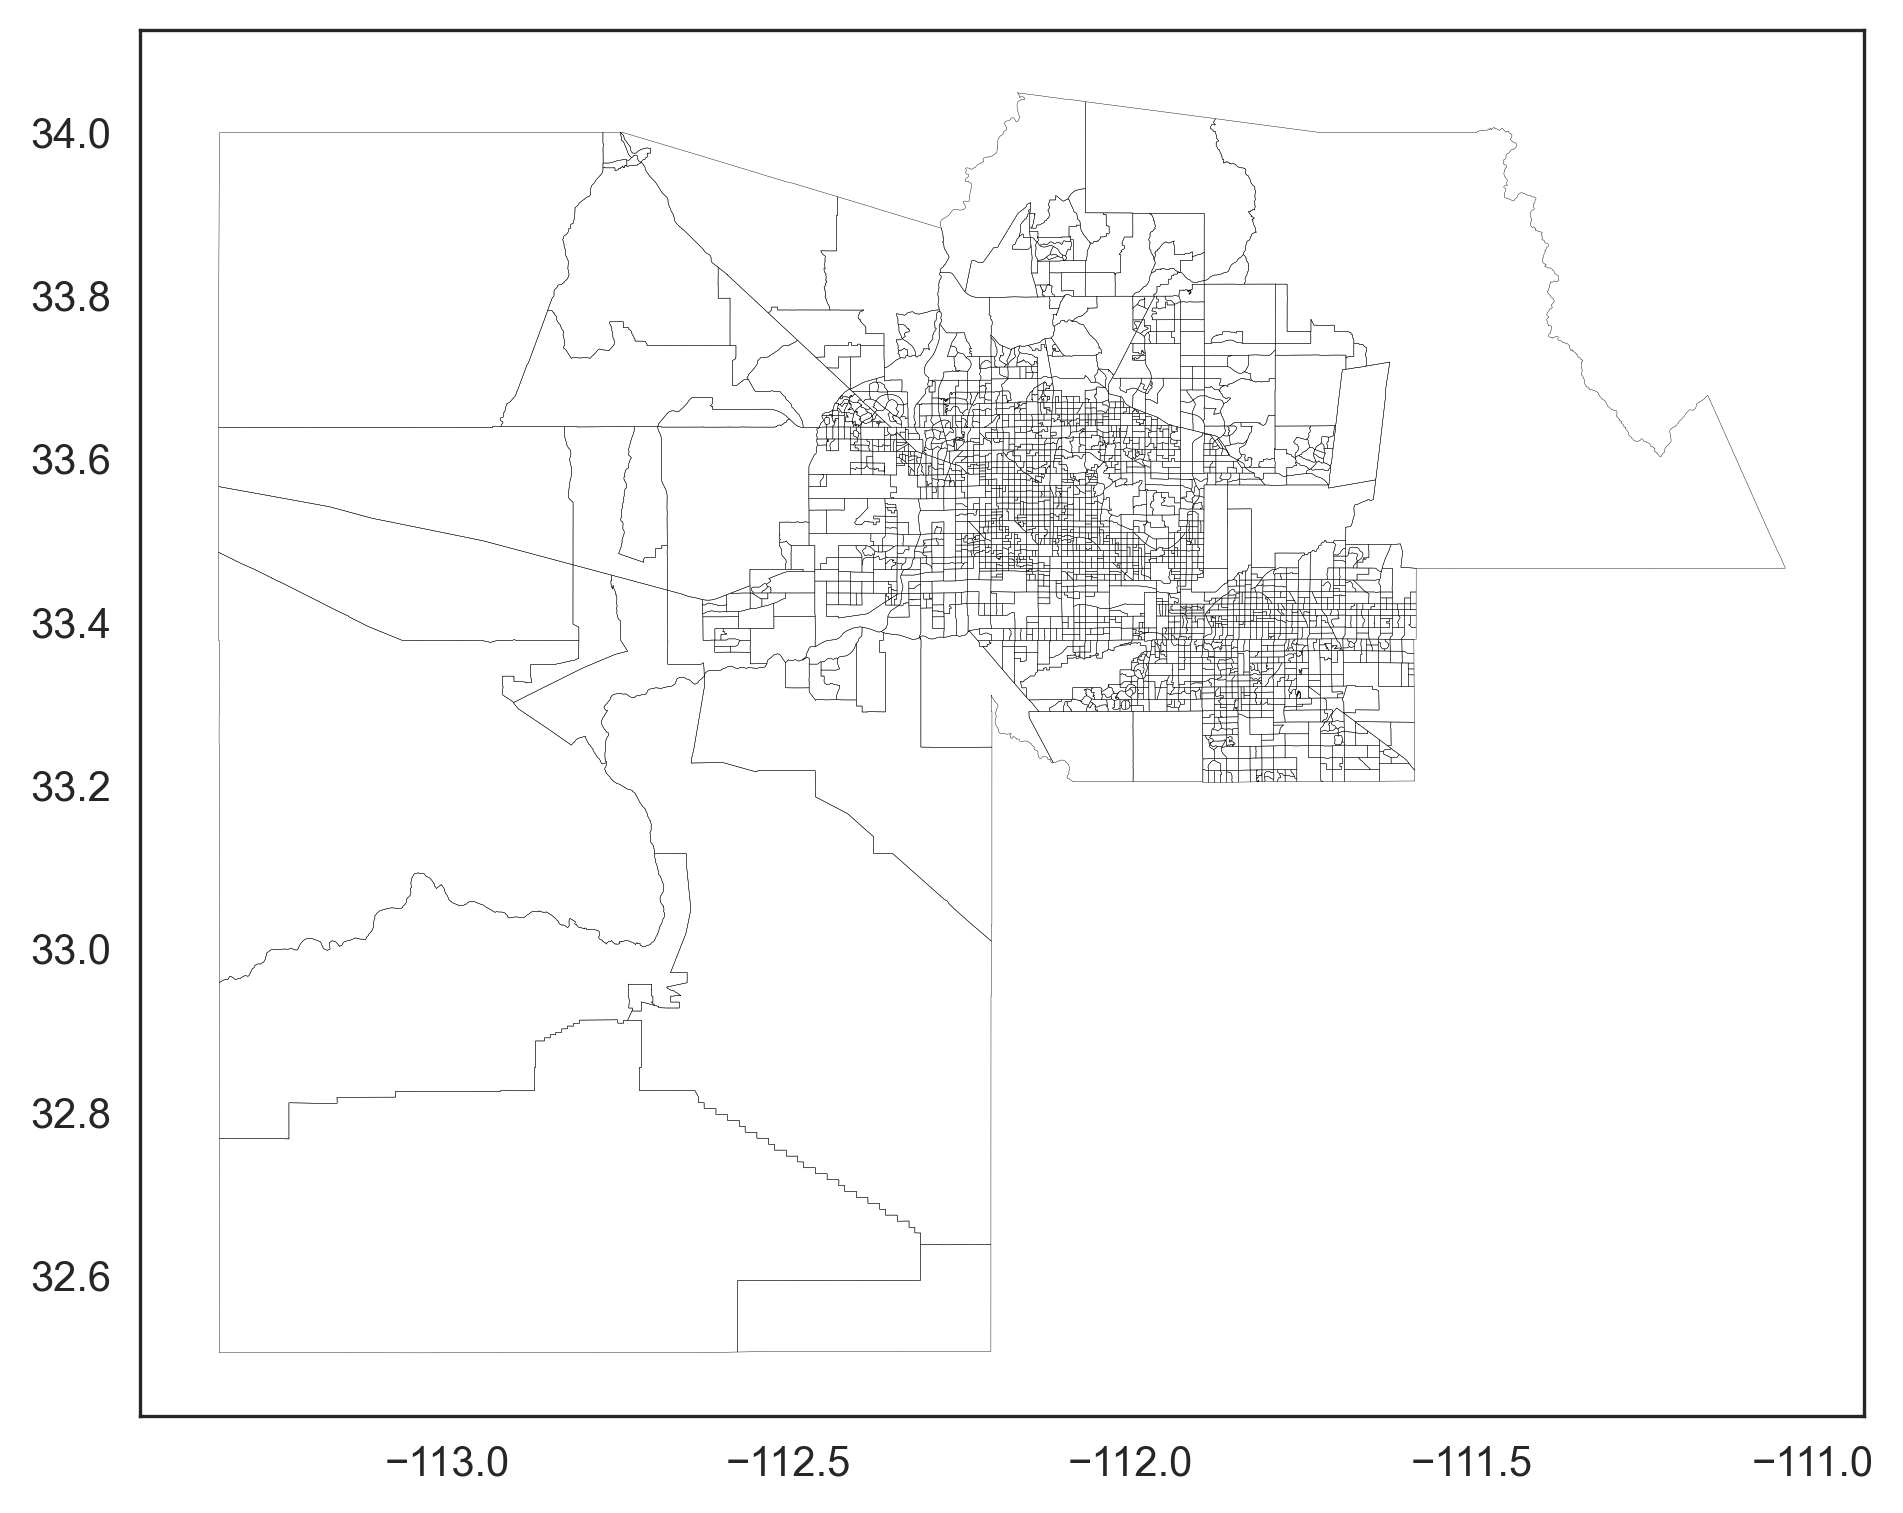

In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 6), dpi=300)  

census_block_groups.plot(linewidth=0.1, ax=ax, edgecolor='black', color='none')
census_block_groups.plot(column='% IMMUNE MMR Weighted', linewidth=0.1, ax=ax, 
                         edgecolor='black', legend=True, 
                         legend_kwds={'label': '% IMMUNE MMR Weighted', 'orientation': 'vertical'},
                         cmap='viridis')  
ax.axis('off')
plt.show()


In [32]:
projected_crs = 'EPSG:26912'

percentage_results = []

for idx, tract in census_block_groups.iterrows():
    tract_gdf = gpd.GeoDataFrame([tract], geometry='geometry', crs=census_block_groups.crs)
    tract_gdf_projected = tract_gdf.to_crs(projected_crs)
    intersection_result = gpd.overlay(tract_gdf_projected, districts.to_crs(projected_crs), how='intersection')

    for idx, district in intersection_result.iterrows():
        intersection_area = district.geometry.area
        total_tract_area = tract_gdf_projected.geometry.area.iloc[0] if tract_gdf_projected.geometry.area.iloc[0] > 0 else 1.0
        percentage_within_district = (intersection_area / total_tract_area) * 100
        
        percentage_results.append({
            'GEOID': tract['GEOID'],  
            'ElemDist': district['NAME'],  
            'PercentageWithinDistrict': percentage_within_district,
        })

/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_1496/1160090737.py:8: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersection_result = gpd.overlay(tract_gdf_projected, districts.to_crs(projected_crs), how='intersection')
/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_1496/1160090737.py:8: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersection_result = gpd.overlay(tract_gdf_projected, districts.to_crs(projected_crs), how='intersection')
/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_1496/1160090737.py:8: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersection_re

# Census


In [33]:
SCHOOL_VARS = [
    "B14007_002E",  # Enrolled in nursery school, preschool
    "B14007_003E",  # Enrolled in kindergarten
    "B14007_004E",  # Enrolled in grade 1
    "B14007_005E",  # Enrolled in grade 2
    "B14007_006E",  # Enrolled in grade 3
    "B14007_007E",  # Enrolled in grade 4
    "B14007_008E",  # Enrolled in grade 5
    "B14007_009E",  # Enrolled in grade 6
    "B14007_010E",  # Enrolled in grade 7 
    "B14007_011E",  # Enrolled in grade 8
    "B14007_012E",  # Enrolled in grade 9
    "B14007_013E",  # Enrolled in grade 10
    "B14007_014E",  # Enrolled in grade 11
    "B14007_015E",  # Enrolled in grade 12
    ]

In [38]:
import pygris

In [39]:
# CBG data
query1 = {'for': 'block group: *',
          'in': f'state: {state_fips} county: {county_fips}'}
cbgs_raw = census.acs5.get([
    "B01003_001E",  # Total Population
], query1, year=YEAR)

cbgs_errollemt_raw = census.acs5.get(SCHOOL_VARS, query1, year=YEAR)

cbgs_geog = pygris.block_groups(
    state=state_fips,
    county=county_fips,
    year=YEAR,
    cache=True
)

In [40]:
cbgs = pd.DataFrame.from_records(cbgs_raw)
cbgs.fillna(0, inplace=True)
cbgs.replace(-666666666, 0, inplace=True)

tract_geoids = cbgs['state'] + cbgs['county'] + cbgs['tract']
geoids = tract_geoids + cbgs['block group']

cbgs = pd.DataFrame({
    'geoid': geoids,
    'population': cbgs['B01003_001E'].astype(np.int64),
})

# Merge geo info
cbgs = cbgs.merge(pd.DataFrame({
    'geoid': cbgs_geog['GEOID'],
    'centroid': cbgs_geog['geometry'].apply(lambda row: row.centroid.coords[0]),
    # TIGER areas are in m^2; divide by 1e6 to get km^2
    'area': cbgs_geog.ALAND / 1e6
}), on='geoid')


cbgs.sort_values(by='geoid', inplace=True)
cbgs.reset_index(drop=True, inplace=True)

cbgs[0:4]

,geoid,population,centroid,area
0,040130101011,1791,"(-111.77075643330394, 33.76924660709943)",18.032622
1,040130101012,2007,"(-111.72000671148204, 33.7410933260103)",29.178977
2,040130101013,1264,"(-111.66697569766907, 33.72404113568911)",6.873642
3,040130101021,1139,"(-111.49136471795472, 33.71546544071483)",2368.942711


In [41]:
cbgs_errollemt = pd.DataFrame.from_records(cbgs_errollemt_raw)
cbgs_errollemt.astype(np.int64)

geoids = cbgs_errollemt['state'] + cbgs_errollemt['county'] + \
    cbgs_errollemt['tract'] + cbgs_errollemt['block group']
cbgs_errollemt.insert(len(cbgs_errollemt.columns), 'geoid', geoids)

cbgs_errollemt = cbgs[['geoid']].merge(cbgs_errollemt, how='inner', on='geoid')
cbgs_errollemt.reset_index(drop=True, inplace=True)
cbgs_errollemt.drop(columns=['geoid'], inplace=True)
cbgs_errollemt

,B14007_002E,B14007_003E,B14007_004E,B14007_005E,B14007_006E,B14007_007E,B14007_008E,B14007_009E,B14007_010E,B14007_011E,B14007_012E,B14007_013E,B14007_014E,B14007_015E,state,county,tract,block group
0,384.0,82.0,0.0,0.0,0.0,33.0,25.0,0.0,0.0,0.0,75.0,20.0,44.0,0.0,04,013,010101,1
1,162.0,66.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,04,013,010101,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,04,013,010101,3
3,91.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,38.0,0.0,04,013,010102,1
4,131.0,0.0,0.0,0.0,28.0,12.0,0.0,28.0,0.0,0.0,0.0,22.0,11.0,0.0,04,013,010102,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,04,013,980100,1
2501,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,04,013,980400,1
2502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,04,013,980500,1
2503,1239.0,60.0,36.0,91.0,67.0,98.0,32.0,131.0,111.0,186.0,69.0,37.0,33.0,36.0,04,013,980600,1


In [42]:
def enrollment_bracketize(cbgs_enrollment: pd.DataFrame) -> pd.DataFrame:
    """Using the enrollment info sum the age groups for elementary, middle, and high school."""

    brackets = {
        "Preschool": ("B14007_002E", "B14007_002E"), # Preschool
        "Elementary": ("B14007_003E", "B14007_008E"),  # Kindergarten to Grade 5
        "Middle": ("B14007_009E", "B14007_011E"),      # Grade 6 to Grade 8
        "High": ("B14007_012E", "B14007_015E")         # Grade 9 to Grade 12
    }

    school_ranges = {}
    for level, (start_var, end_var) in brackets.items():
        start_index = SCHOOL_VARS.index(start_var)
        end_index = SCHOOL_VARS.index(end_var) + 1
        school_ranges[level] = (start_index, end_index)

    return pd.DataFrame({
        level: cbgs_enrollment.iloc[:, start:end].sum(axis=1)
        for level, (start, end) in school_ranges.items()
    }, dtype=np.int64)

enrollment_summary = enrollment_bracketize(cbgs_errollemt)
enrollment_summary[0:4]

,Preschool,Elementary,Middle,High
0,384,140,0,139
1,162,106,0,16
2,0,0,0,0
3,91,10,0,48


In [43]:
data = {
    'label': cbgs['geoid'].to_numpy(dtype=np.str_),
    'centroid': cbgs['centroid'].to_numpy(dtype=CentroidDType),
    'population': cbgs['population'].to_numpy(dtype=np.int64),

    'population_by_school': enrollment_summary.to_numpy(dtype=np.int64),
}
			
def save_compressed_geo(id, data):
    if not 'label' in data:
        msg = f"Geo {id} must have a 'label' attribute in order to be saved and loaded."
        raise Exception(msg)
    
    file_path = os.path.expanduser(f'~/Desktop/Github/EpiMoRPH-Modeling/social-determinate-of-health/scratch/Movement_model/{id}_geo.npz')
    
    np.savez_compressed(file_path, **data)

# Call the function with the provided arguments
save_compressed_geo('school_cbg_2019', data)

In [44]:
census_df = pd.DataFrame({k: list(v) for k, v in data.items()})
census_df

,label,centroid,population,population_by_school
0,040130101011,"[-111.77075643330394, 33.76924660709943]",1791,"[384, 140, 0, 139]"
1,040130101012,"[-111.72000671148204, 33.7410933260103]",2007,"[162, 106, 0, 16]"
2,040130101013,"[-111.66697569766907, 33.72404113568911]",1264,"[0, 0, 0, 0]"
3,040130101021,"[-111.49136471795472, 33.71546544071483]",1139,"[91, 10, 0, 48]"
4,040130101022,"[-111.8505100649063, 33.82609833466325]",1487,"[131, 40, 28, 33]"
...,...,...,...,...
2500,040139801001,"[-112.88186166490277, 32.66947221385736]",0,"[0, 0, 0, 0]"
2501,040139804001,"[-111.95879092988882, 33.298073567638134]",13,"[5, 0, 0, 0]"
2502,040139805001,"[-111.88633119332626, 33.24392529871578]",0,"[0, 0, 0, 0]"
2503,040139806001,"[-111.61909767565444, 33.33555256790642]",4291,"[1239, 384, 428, 175]"


In [27]:
import numpy as np


In [40]:
theta = 0.92
rate = theta * data['population']
poisson_distributed_values = np.array([np.random.poisson(lam=theta * pop) for pop in data['population']])

poisson_distributed_values

array([1646, 1943, 1115, ...,    0, 3968,    0])

In [ ]:
np.floor(data['rate'])

In [50]:
rate = np.floor(theta * data['population'])
rate

array([1647., 1846., 1162., ...,    0., 3947.,    0.])

In [53]:
import numpy as np
import pandas as pd

theta = 0.92

census_df['rate'] = np.floor(theta * census_df['population'])
census_df['vaccinated'] = np.random.poisson(lam=census_df['rate'].values)

census_df[['population', 'vaccinated', 'rate']]

,population,vaccinated,rate
0,1791,1634,1647.0
1,2007,1889,1846.0
2,1264,1165,1162.0
3,1139,1019,1047.0
4,1487,1392,1368.0
...,...,...,...
2500,0,0,0.0
2501,13,8,11.0
2502,0,0,0.0
2503,4291,3978,3947.0


In [41]:
census_df[['population','vaccinated']]

,population,vaccinated
0,1791,1829
1,2007,1974
2,1264,1264
3,1139,1138
4,1487,1517
...,...,...
2500,0,0
2501,13,11
2502,0,0
2503,4291,4290


In [45]:
geometry = [Point(xy) for xy in zip(Measles_school_coverage['School_Coords_Lon'], Measles_school_coverage['School_Coords_Lat'])]

# Create a GeoDataFrame using the original DataFrame and the geometry list
gdf = gpd.GeoDataFrame(Measles_school_coverage, geometry=geometry)

# Set the coordinate reference system (CRS) to EPSG:4269
gdf.set_crs(epsg=4269, inplace=True)
gdf

,SCHOOL NAME,ADDRESS,CITY,COUNTY,ZIP,SCHOOL NURSE,SCHOOL NURSE TYPE,ENROLLED,% IMMUNE MMR,% EXEMPT MMR,% COMPLIANCE MMR,SCHOOL TYPE,key,School_Coords_Lat,School_Coords_Lon,GEOID,Weighted_IMMUNE,geometry
0,1ST ACADEMY PRESCHOOL & CHILD CARE,1133 S DOBSON RD,MESA,MARICOPA,85202,NO,NaN,55.0,1.000000,0.000000,1.000000,NaN,1133SDOBSONRD,33.394645,-111.874537,040134221033,55.0,POINT (-111.87454 33.39465)
1,5TH PLACE COMMUNITY CHILD CARE,306 W 5TH PL,MESA,MARICOPA,85201,NO,NaN,NaN,1.000000,0.000000,1.000000,NaN,306W5THPL,33.425211,-111.838970,040134210012,NaN,POINT (-111.83897 33.42521)
2,91ST PSALM CHRISTIAN SCHOOL,2020 EAST BASELINE ROAD,PHOENIX,MARICOPA,85042,NO,NaN,NaN,0.812500,0.187500,1.000000,NaN,2020EASTBASELINEROAD,33.377931,-112.038373,040131163003,NaN,POINT (-112.03837 33.37793)
3,A CHILD''S PLACE AT THE RANCHES LLC,3636 S ATHERTON BLVD,GILBERT,MARICOPA,85297,NO,NaN,45.0,0.955556,0.022222,0.977778,NaN,3636SATHERTONBLVD,33.284575,-111.716741,040138157002,43.0,POINT (-111.71674 33.28457)
4,"A GREAT BEGINNING, INC.",13380 W VAN BUREN ST,GOODYEAR,MARICOPA,85338,NO,NaN,74.0,0.972973,0.027027,1.000000,NaN,13380WVANBURENST,NaN,NaN,NaN,72.0,POINT EMPTY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,POMEROY ELEMENTARY SCHOOL,1507 W SHAWNEE DR,CHANDLER,MARICOPA,85224,YES,RN,67.0,1.000000,0.000000,1.000000,PUBLIC,1507WSHAWNEEDR,33.344243,-111.867736,040134222101,67.0,POINT (-111.86774 33.34424)
2326,HIGHLAND ELEMENTARY SCHOOL,3042 E ADOBE ST,MESA,MARICOPA,85213,YES,RN,90.0,0.966667,0.033333,1.000000,PUBLIC,3042EADOBEST,33.430043,-111.765115,040134207043,87.0,POINT (-111.76512 33.43004)
2327,CRISMON ELEMENTARY SCHOOL,825 W MEDINA AVE,MESA,MARICOPA,85210,YES,RN,60.0,0.950000,0.050000,1.000000,PUBLIC,825WMEDINAAVE,33.371443,-111.853396,040134222162,57.0,POINT (-111.85340 33.37144)
2328,ST. LOUIS THE KING PRE-KINDERGARTEN AND EXTEND...,4331 W MARYLAND AVE,GLENDALE,MARICOPA,85301,NO,NaN,24.0,0.958333,0.000000,1.000000,PRIVATE,4331WMARYLANDAVE,33.531130,-112.153975,040130930023,23.0,POINT (-112.15397 33.53113)


In [46]:
census_df['vaccinated'] = census_df['population'].apply(lambda x: np.random.poisson(lam=x))
explicit_df = census_df[['population','vaccinated']]
explicit_df.loc[:, 'population'] = explicit_df['population'] - explicit_df['vaccinated']
explicit_df

,population,vaccinated
0,-11,1802
1,38,1969
2,7,1257
3,-2,1141
4,-9,1496
...,...,...
2500,0,0
2501,-4,17
2502,0,0
2503,116,4175


# Precentage Diagram


In [48]:
projected_crs = 'EPSG:26912'

percentage_results = []

for idx, tract in census_block_groups.iterrows():
    tract_gdf = gpd.GeoDataFrame([tract], geometry='geometry', crs=census_block_groups.crs)
    tract_gdf_projected = tract_gdf.to_crs(projected_crs)
    intersection_result = gpd.overlay(tract_gdf_projected, districts.to_crs(projected_crs), how='intersection')

    for idx, district in intersection_result.iterrows():
        intersection_area = district.geometry.area
        total_tract_area = tract_gdf_projected.geometry.area.iloc[0] if tract_gdf_projected.geometry.area.iloc[0] > 0 else 1.0
        percentage_within_district = (intersection_area / total_tract_area) * 100
        
        percentage_results.append({
            'GEOID': tract['GEOID'],  
            'ElemDist': district['NAME'],  
            'PercentageWithinDistrict': percentage_within_district,
        })

/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_1496/1160090737.py:8: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersection_result = gpd.overlay(tract_gdf_projected, districts.to_crs(projected_crs), how='intersection')
/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_1496/1160090737.py:8: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersection_result = gpd.overlay(tract_gdf_projected, districts.to_crs(projected_crs), how='intersection')
/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_1496/1160090737.py:8: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersection_re

In [51]:
precentage_schools = schools_in_intersection_cbg[['NCES School ID', 'GEOID','NAME', 'School Name', 'Students', 'school type']]
precentage_schools

,NCES School ID,GEOID,NAME,School Name,Students,school type
3,40010601892,040136196001,Paradise Valley Unified District,AAEC - Paradise Valley,316.0,High School
18,40089103604,040130719111,Peoria Unified School District,Academy of Math and Science Peoria Advanced,791.0,Elementary/Middle School
24,40027601841,040134208003,Mesa Unified District,Academy with Community Partners,171.0,High School
25,40012101581,040131051012,Scottsdale Unified District,Accelerated Learning Center,153.0,High School
29,40497000378,040134221022,Mesa Unified District,Adams Elementary School,629.0,Elementary/Middle School
...,...,...,...,...,...,...
2260,40497001667,040134226381,Mesa Unified District,Wilson Elementary School,465.0,Elementary/Middle School
2268,40717002808,040130506041,Saddle Mountain Unified School District,Winters Well Elementary School,578.0,Elementary School
2274,40757000666,040132182002,Scottsdale Unified District,Yavapai Elementary School,387.0,Elementary/Middle School
2284,40497002280,040134201102,Mesa Unified District,Zaharis Elementary,769.0,Elementary/Middle School


In [52]:
from geo_builder import census_df


Using FIPS code '04' for input 'AZ'
Using FIPS code '013' for input 'Maricopa'
Using FIPS code '04' for input 'AZ'


In [53]:
percentage_results_df = pd.DataFrame(percentage_results)

pivoted_df = percentage_results_df.pivot_table(index='GEOID', columns='ElemDist', values='PercentageWithinDistrict', aggfunc='mean')
pivoted_df = pivoted_df.fillna(0)
pivoted_df = pivoted_df.reset_index()
pivoted_df.iloc[:, 1:] = pivoted_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
pivoted_df['Tract School District'] = pivoted_df.iloc[:, 1:].idxmax(axis=1)

color_mapping = dict(zip(districts['NAME'], districts['color']))
pivoted_df['precent color'] = pivoted_df['Tract School District'].map(color_mapping)


data_df_1 = pivoted_df[["GEOID", "Tract School District", "precent color"]]

merged_df = pd.merge(left=pd.merge(census_block_groups, data_df_1, on='GEOID', how='inner'),
                     right=census_df,
                     left_on='GEOID', 
                     right_on='label', 
                     how='inner')

# Merge with precentage_schools
merged_df = pd.merge(merged_df, precentage_schools, on='GEOID', how='left')

# Fill NaN values with 0 and drop duplicates based on 'GEOID'
merged_df.fillna(0, inplace=True)
merged_df.drop_duplicates(subset=['GEOID'], inplace=True)

percentage_gpd_df = gpd.GeoDataFrame(merged_df).reset_index()
percentage_gpd_df

,index,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,centroid,area km^2,population,population_MOE,population_by_school,NCES School ID,NAME,School Name,Students,school type
0,0,04,013,421702,3,040134217023,Block Group 3,G5030,S,310375,...,"[-111.77888679450112, 33.41230437637614]",0,1187,401.0,"[294, 114, 99, 76]",0.000000e+00,0,0,0.0,0
1,1,04,013,040531,2,040130405312,Block Group 2,G5030,S,616061,...,"[-112.37221038348787, 33.64226599349936]",0,723,124.0,"[0, 0, 0, 0]",0.000000e+00,0,0,0.0,0
2,2,04,013,092721,1,040130927211,Block Group 1,G5030,S,1108648,...,"[-112.24727481754334, 33.54087387007472]",1,2220,330.0,"[696, 220, 94, 108]",0.000000e+00,0,0,0.0,0
3,3,04,013,010102,1,040130101021,Block Group 1,G5030,S,2368942711,...,"[-111.49136471795472, 33.71546544071483]",2368,1139,438.0,"[91, 10, 0, 48]",0.000000e+00,0,0,0.0,0
4,4,04,013,030402,1,040130304021,Block Group 1,G5030,S,36227532,...,"[-111.92837484059403, 33.876666314610155]",36,647,182.0,"[33, 0, 12, 12]",0.000000e+00,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506,1725,04,013,811900,2,040138119002,Block Group 2,G5030,S,771839,...,"[-111.863861719916, 33.280102590622505]",0,1297,371.0,"[379, 136, 0, 88]",0.000000e+00,0,0,0.0,0
1507,1726,04,013,812000,1,040138120001,Block Group 1,G5030,S,1279036,...,"[-111.85010336939861, 33.28021588515062]",1,2951,690.0,"[952, 364, 255, 118]",0.000000e+00,0,0,0.0,0
1508,1727,04,013,812000,2,040138120002,Block Group 2,G5030,S,1360898,...,"[-111.85021278160758, 33.28768637874011]",1,2038,360.0,"[418, 77, 82, 49]",0.000000e+00,0,0,0.0,0
1509,1728,04,013,523002,3,040135230023,Block Group 3,G5030,S,666349,...,"[-111.85467146671873, 33.30970283397538]",0,1328,371.0,"[331, 135, 58, 101]",0.000000e+00,0,0,0.0,0


In [54]:
percentage_dissolved_gdf = percentage_gpd_df.dissolve(by='Tract School District').reset_index()

percentage_dissolved_gdf

,Tract School District,geometry,index,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,...,centroid,area km^2,population,population_MOE,population_by_school,NCES School ID,NAME,School Name,Students,school type
0,Cave Creek Unified District,"POLYGON ((-111.99551 33.73703, -111.99550 33.7...",4,04,013,030402,1,040130304021,Block Group 1,G5030,...,"[-111.92837484059403, 33.876666314610155]",36,647,182.0,"[33, 0, 12, 12]",0.000000e+00,0,0,0.0,0
1,Chandler Unified District,"POLYGON ((-111.86816 33.20360, -111.86890 33.2...",25,04,013,810300,2,040138103002,Block Group 2,G5030,...,"[-111.87956966170388, 33.32626216724471]",0,1094,311.0,"[296, 51, 21, 78]",0.000000e+00,0,0,0.0,0
2,Deer Valley Unified District,"POLYGON ((-112.18779 33.63869, -112.19082 33.6...",9,04,013,614800,2,040136148002,Block Group 2,G5030,...,"[-112.0874396989669, 33.67281200048]",0,1410,283.0,"[309, 82, 14, 98]",0.000000e+00,0,0,0.0,0
3,Dysart Unified District,"POLYGON ((-112.47025 33.56617, -112.47026 33.5...",1,04,013,040531,2,040130405312,Block Group 2,G5030,...,"[-112.37221038348787, 33.64226599349936]",0,723,124.0,"[0, 0, 0, 0]",0.000000e+00,0,0,0.0,0
4,Fountain Hills Unified District,"POLYGON ((-111.77011 33.57517, -111.77008 33.5...",125,04,013,216819,1,040132168191,Block Group 1,G5030,...,"[-111.76522395702263, 33.625785476118736]",13,2522,354.0,"[270, 33, 58, 76]",0.000000e+00,0,0,0.0,0
5,Gila Bend Unified District,"POLYGON ((-113.33381 32.51288, -113.33379 32.5...",867,04,013,980100,1,040139801001,Block Group 1,G5030,...,"[-112.88186166490277, 32.66947221385736]",2912,0,12.0,"[0, 0, 0, 0]",0.000000e+00,0,0,0.0,0
6,Gilbert Unified District,"POLYGON ((-111.79051 33.32093, -111.79166 33.3...",49,04,013,422621,1,040134226211,Block Group 1,G5030,...,"[-111.71423041341606, 33.37618584395918]",1,1405,347.0,"[379, 178, 68, 96]",0.000000e+00,0,0,0.0,0
7,Higley Unified District,"POLYGON ((-111.73804 33.25344, -111.73803 33.2...",443,04,013,816200,2,040138162002,Block Group 2,G5030,...,"[-111.69466237164951, 33.27485878850009]",1,2972,304.0,"[990, 360, 300, 158]",4.037800e+10,Higley Unified District,Power Ranch Elementary,623.0,Elementary/Middle School
8,Mesa Unified District,"POLYGON ((-111.86429 33.33510, -111.86530 33.3...",0,04,013,421702,3,040134217023,Block Group 3,G5030,...,"[-111.77888679450112, 33.41230437637614]",0,1187,401.0,"[294, 114, 99, 76]",0.000000e+00,0,0,0.0,0
9,Nadaburg Unified School District,"POLYGON ((-112.39474 33.73559, -112.39474 33.7...",1073,04,013,040517,1,040130405171,Block Group 1,G5030,...,"[-112.55631260759617, 33.75865650720162]",68,4331,811.0,"[1088, 204, 246, 289]",0.000000e+00,0,0,0.0,0


In [55]:
preschools = schools_in_intersection_cbg[
    schools_in_intersection_cbg['school type'].isin(['Preschool'])]
preschools_names = preschools['School Name'].tolist()

elementary_schools = schools_in_intersection_cbg[
    schools_in_intersection_cbg['school type'].isin(['Elementary School', 'Elementary/Middle School', 'Elementary/Middle/High School'])]
elementary_schools_names = elementary_schools['School Name'].tolist()

middle_schools = schools_in_intersection_cbg[
    schools_in_intersection_cbg['school type'].isin(['Middle School', 'Elementary/Middle School', 'Middle/High School', 'Elementary/Middle/High School'])]
middle_schools_names = middle_schools['School Name'].tolist()

high_schools = schools_in_intersection_cbg[
    schools_in_intersection_cbg['school type'].isin(['High School', 'Middle/High School', 'Elementary/Middle/High School'])]
high_schools_names = high_schools['School Name'].tolist()

In [56]:
num_preschools = len(preschools)
num_elementary_schools = len(elementary_schools)
num_middle_schools = len(middle_schools)
num_high_schools = len(high_schools)
num_census_blocks= len(census_block_groups)
nearest_preschools = np.zeros((num_census_blocks, num_preschools))
nearest_elementary_schools = np.zeros((num_census_blocks, num_elementary_schools))
nearest_middle_schools = np.zeros((num_census_blocks, num_middle_schools))
nearest_high_schools= np.zeros((num_census_blocks, num_high_schools))

students_preschools = np.zeros((num_census_blocks, num_preschools))
students_elementary_schools = np.zeros((num_census_blocks, num_elementary_schools))
students_middle_schools = np.zeros((num_census_blocks, num_middle_schools))
students_high_schools= np.zeros((num_census_blocks, num_high_schools))

In [57]:
labels = census_df['label'].tolist()

matrix_df = pd.DataFrame(0, index=labels, columns=labels)
matrix_df

,040130101011,040130101012,040130101013,040130101021,040130101022,040130101023,040130304011,040130304012,040130304013,040130304021,...,040139412001,040139413001,040139413002,040139413003,040139413004,040139801001,040139804001,040139805001,040139806001,040139807001
040130101011,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
040130101012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
040130101013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
040130101021,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
040130101022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
040139801001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
040139804001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
040139805001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
040139806001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
percentage_gpd_df['Tract School District']

0                Mesa Unified District
1              Dysart Unified District
2       Peoria Unified School District
3          School District Not Defined
4          Cave Creek Unified District
                     ...              
1506         Chandler Unified District
1507         Chandler Unified District
1508         Chandler Unified District
1509         Chandler Unified District
1510         Chandler Unified District
Name: Tract School District, Length: 1511, dtype: object

In [60]:
percentage_gpd_df

,index,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,centroid,area km^2,population,population_MOE,population_by_school,NCES School ID,NAME,School Name,Students,school type
0,0,04,013,421702,3,040134217023,Block Group 3,G5030,S,310375,...,"[-111.77888679450112, 33.41230437637614]",0,1187,401.0,"[294, 114, 99, 76]",0.000000e+00,0,0,0.0,0
1,1,04,013,040531,2,040130405312,Block Group 2,G5030,S,616061,...,"[-112.37221038348787, 33.64226599349936]",0,723,124.0,"[0, 0, 0, 0]",0.000000e+00,0,0,0.0,0
2,2,04,013,092721,1,040130927211,Block Group 1,G5030,S,1108648,...,"[-112.24727481754334, 33.54087387007472]",1,2220,330.0,"[696, 220, 94, 108]",0.000000e+00,0,0,0.0,0
3,3,04,013,010102,1,040130101021,Block Group 1,G5030,S,2368942711,...,"[-111.49136471795472, 33.71546544071483]",2368,1139,438.0,"[91, 10, 0, 48]",0.000000e+00,0,0,0.0,0
4,4,04,013,030402,1,040130304021,Block Group 1,G5030,S,36227532,...,"[-111.92837484059403, 33.876666314610155]",36,647,182.0,"[33, 0, 12, 12]",0.000000e+00,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506,1725,04,013,811900,2,040138119002,Block Group 2,G5030,S,771839,...,"[-111.863861719916, 33.280102590622505]",0,1297,371.0,"[379, 136, 0, 88]",0.000000e+00,0,0,0.0,0
1507,1726,04,013,812000,1,040138120001,Block Group 1,G5030,S,1279036,...,"[-111.85010336939861, 33.28021588515062]",1,2951,690.0,"[952, 364, 255, 118]",0.000000e+00,0,0,0.0,0
1508,1727,04,013,812000,2,040138120002,Block Group 2,G5030,S,1360898,...,"[-111.85021278160758, 33.28768637874011]",1,2038,360.0,"[418, 77, 82, 49]",0.000000e+00,0,0,0.0,0
1509,1728,04,013,523002,3,040135230023,Block Group 3,G5030,S,666349,...,"[-111.85467146671873, 33.30970283397538]",0,1328,371.0,"[331, 135, 58, 101]",0.000000e+00,0,0,0.0,0


In [59]:
for i in range(num_census_blocks):
    tract_district = percentage_gpd_df['Tract School District'][i]
    student_home_cbg = percentage_gpd_df['GEOID'][i]
    students_population_cbg = percentage_gpd_df['population_by_age'][i][:3]
    
    for j in range(num_preschools):
        school_district = preschools['NAME'].iloc[j]
        school_district_cbg = preschools['GEOID'].iloc[j]
        school_district_population = preschools['Students*'].iloc[j]

        if tract_district == school_district:
            try:
                nearest_preschools[i, j] = haversine(percentage_gpd_df['centroid'][i][0], 
                                                            percentage_gpd_df['centroid'][i][1],
                                                            preschools['coords'].iloc[j][0], 
                                                            preschools['coords'].iloc[j][1])
                matrix_df.at[student_home_cbg, school_district_cbg] = students_population_cbg[0]

            except KeyError:
                print(f"KeyError encountered at index: {j}")
        else:
            nearest_elementary_schools[i, j] = None

    for j in range(num_elementary_schools):
        school_district = elementary_schools['NAME'].iloc[j]
        school_district_cbg = elementary_schools['GEOID'].iloc[j]
        school_district_population = elementary_schools['Students*'].iloc[j]

        if tract_district == school_district:
            try:
                nearest_elementary_schools[i, j] = haversine(percentage_gpd_df['centroid'][i][0], 
                                                            percentage_gpd_df['centroid'][i][1],
                                                            elementary_schools['coords'].iloc[j][0], 
                                                            elementary_schools['coords'].iloc[j][1])
                matrix_df.at[student_home_cbg, school_district_cbg] = students_population_cbg[0]

            except KeyError:
                print(f"KeyError encountered at index: {j}")
        else:
            nearest_elementary_schools[i, j] = None

    for j in range(num_middle_schools):
        school_district = middle_schools['NAME'].iloc[j]
        school_district_cbg = middle_schools['GEOID'].iloc[j]
        school_district_population = middle_schools['Students*'].iloc[j]

        if tract_district == school_district:
            try:
                nearest_middle_schools[i, j] = haversine(percentage_gpd_df['centroid'][i][0], 
                                                            percentage_gpd_df['centroid'][i][1],
                                                            middle_schools['coords'].iloc[j][0], 
                                                            middle_schools['coords'].iloc[j][1])
                matrix_df.at[student_home_cbg, school_district_cbg] = students_population_cbg[1].sum()
            except KeyError:
                print(f"KeyError encountered at index: {j}")
        else:
            nearest_middle_schools[i, j] = None

    for j in range(num_high_schools):
        school_district = high_schools['NAME'].iloc[j]
        school_district_cbg = high_schools['GEOID'].iloc[j]
        school_district_population = high_schools['Students*'].iloc[j]

        if tract_district == school_district:
            try:
                students_high_schools[i, j] = haversine(percentage_gpd_df['centroid'][i][0], 
                                                            percentage_gpd_df['centroid'][i][1],
                                                            high_schools['coords'].iloc[j][0], 
                                                            high_schools['coords'].iloc[j][1])
                matrix_df.at[student_home_cbg, school_district_cbg] = students_population_cbg[1].sum()
            except KeyError:
                print(f"KeyError encountered at index: {j}")
        else:
            students_high_schools[i, j] = None

KeyError: 'population_by_age'

In [ ]:
def get_nearest_school(df):
    if df.empty or df.isna().all().all():
        return pd.Series([None] * len(df), index=df.index)
    else:
        return df.idxmin(axis=1)

nearest_elementary_school_df = pd.DataFrame(nearest_elementary_schools, columns = elementary_schools_names)
nearest_middle_school_df = pd.DataFrame(nearest_middle_schools, columns = middle_schools_names)
nearest_high_schools_df = pd.DataFrame(nearest_high_schools, columns = high_schools_names)

nearest_elementary = get_nearest_school(nearest_elementary_school_df)
nearest_middle = get_nearest_school(nearest_middle_school_df)
nearest_high = get_nearest_school(nearest_high_schools_df)

closest_elementary_df = pd.DataFrame(nearest_elementary, columns=["Elementary School Name"])
closest_middle_df = pd.DataFrame(nearest_middle, columns=[" Middle School Name"])
closest_high_df = pd.DataFrame(nearest_high, columns=["High School Name"])


In [ ]:
percentage_Voronoi_gpd['geo']

In [ ]:
schools_in_intersection_cbg_NCES_MMR

In [ ]:
data_df = pd.concat([percentage_gpd_df, closest_elementary_df, closest_middle_df, closest_high_df ], axis=1)

percentage_Voronoi_gpd = gpd.GeoDataFrame(data_df)
percentage_Voronoi_gpd

In [ ]:
percentage_Voronoi_gpd.columns


In [ ]:
percentage_dissolved_gdf = percentage_gpd_df.dissolve(by='Tract School District').reset_index()
3
percentage_dissolved_gdf

# Plots


In [44]:
census_block_groups_dissolved_gdf = census_block_groups.dissolve(by='STATEFP').reset_index()
census_block_groups_dissolved_gdf

,STATEFP,geometry,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
0,04,"POLYGON ((-112.20358 32.57924, -112.20359 32.5...",013,421702,3,040134217023,Block Group 3,G5030,S,310375,0,+33.4123043,-111.7788867


In [43]:
county_districts = pd.merge(schools_in_intersection_cbg, districts, on='NAME', how='inner')
county_districts = gpd.GeoDataFrame(county_districts)
county_districts.rename(columns={'geometry_x': 'geometry_schools', 'geometry_y': 'geometry'}, inplace=True)

county_districts

,NCES School ID,Low Grade*,High Grade*,School Name,District,Locale Code*,Locale*,Title I School*,Title 1 School Wide*,Students*,...,SDTYP_y,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,color_y,Centroid_y,coords_y
0,40010601892,09,12,AAEC - Paradise Valley,Arizona Agribusiness & Equine Center Inc. (4331),11,City: Large,Yes,No,322.0,...,NaN,E,253218847,500050,+33.6534512,-111.9799825,"POLYGON ((-112.08285 33.66854, -112.08234 33.6...","(0.41568627450980394, 0.7019607843137254, 0.99...",POINT (-111.97802 33.64014),"(-111.97801767944645, 33.6401435)"
1,40593001553,07,12,Paradise Valley High School,Paradise Valley Unified District (4241),11,City: Large,Yes,Yes,1865.0,...,NaN,E,253218847,500050,+33.6534512,-111.9799825,"POLYGON ((-112.08285 33.66854, -112.08234 33.6...","(0.41568627450980394, 0.7019607843137254, 0.99...",POINT (-111.97802 33.64014),"(-111.97801767944645, 33.6401435)"
2,40061502654,09,12,West-MEC - Paradise Valley High School,West-MEC - Western Maricopa Education Center (...,11,City: Large,No,†,25.0,...,NaN,E,253218847,500050,+33.6534512,-111.9799825,"POLYGON ((-112.08285 33.66854, -112.08234 33.6...","(0.41568627450980394, 0.7019607843137254, 0.99...",POINT (-111.97802 33.64014),"(-111.97801767944645, 33.6401435)"
3,40091803426,KG,06,Arizona Language Preparatory,Arizona Language Preparatory (92566),11,City: Large,No,†,73.0,...,NaN,E,253218847,500050,+33.6534512,-111.9799825,"POLYGON ((-112.08285 33.66854, -112.08234 33.6...","(0.41568627450980394, 0.7019607843137254, 0.99...",POINT (-111.97802 33.64014),"(-111.97801767944645, 33.6401435)"
4,40084303351,05,12,BASIS Phoenix,BASIS Charter Schools Inc. (91280),11,City: Large,No,†,730.0,...,NaN,E,253218847,500050,+33.6534512,-111.9799825,"POLYGON ((-112.08285 33.66854, -112.08234 33.6...","(0.41568627450980394, 0.7019607843137254, 0.99...",POINT (-111.97802 33.64014),"(-111.97801767944645, 33.6401435)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,40717000620,PK,12,Ruth Fisher Middle School,Saddle Mountain Unified School District (4254),42,Rural: Distant,No,†,726.0,...,NaN,E,1422535338,137597,+33.5467843,-112.8634044,"POLYGON ((-113.33506 33.58286, -113.33505 33.5...","(0.12549019607843137, 0.2784313725490196, 0.28...",POINT (-112.76884 33.50926),"(-112.7688428443478, 33.509262)"
614,40717002483,07,12,Tonopah Valley High School,Saddle Mountain Unified School District (4254),42,Rural: Distant,No,†,801.0,...,NaN,E,1422535338,137597,+33.5467843,-112.8634044,"POLYGON ((-113.33506 33.58286, -113.33505 33.5...","(0.12549019607843137, 0.2784313725490196, 0.28...",POINT (-112.76884 33.50926),"(-112.7688428443478, 33.509262)"
615,40061502440,07,12,West-MEC - Tonopah Valley High School,West-MEC - Western Maricopa Education Center (...,42,Rural: Distant,No,†,5.0,...,NaN,E,1422535338,137597,+33.5467843,-112.8634044,"POLYGON ((-113.33506 33.58286, -113.33505 33.5...","(0.12549019607843137, 0.2784313725490196, 0.28...",POINT (-112.76884 33.50926),"(-112.7688428443478, 33.509262)"
616,40717002812,KG,05,Tartesso Elementary School,Saddle Mountain Unified School District (4254),42,Rural: Distant,No,†,855.0,...,NaN,E,1422535338,137597,+33.5467843,-112.8634044,"POLYGON ((-113.33506 33.58286, -113.33505 33.5...","(0.12549019607843137, 0.2784313725490196, 0.28...",POINT (-112.76884 33.50926),"(-112.7688428443478, 33.509262)"


In [ ]:
dpi = 300

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

roads.plot(ax=ax, color='black', linewidth=0.2)

districts.plot(linewidth=0.05, ax=ax, edgecolor='black', color = districts['color'])
census_counties.plot(linewidth=1, ax=ax, edgecolor='black', color = 'none')


ax.axis('off')

plt.savefig(f'{powerpoint}/{STATE}_districts.png', dpi=dpi, bbox_inches='tight')

plt.title(f'{STATE} School Districts')
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

roads.plot(ax=ax, color='blue', linewidth=0.2)
census_counties.plot(linewidth=1, ax=ax, edgecolor='black', color = 'none')

ax.axis('off')

plt.savefig(f'{powerpoint}/{STATE}_counties.png', dpi=300, bbox_inches='tight')

plt.title(f'{STATE} Counties')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

roads.plot(ax=ax, color='blue', linewidth=0.2)
districts.plot(linewidth=0.05, ax=ax, edgecolor='black', color = districts['color'])
census_counties.plot(linewidth=1, ax=ax, edgecolor='black', color = 'none')
census_block_groups_dissolved_gdf.plot(linewidth=1, ax=ax, edgecolor = 'red', color = 'red')

ax.axis('off')

plt.savefig(f'{powerpoint}/selcted_{STATE}_counties.png', dpi=dpi, bbox_inches='tight')

plt.title(f'{STATE} Counties')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

census_block_groups.plot(linewidth=0.2, ax=ax, edgecolor='black', color='none')

ax.axis('off')

plt.savefig(f'{powerpoint}/selected_{COUNTY}_county_districts_Voronoi.png', dpi=dpi, bbox_inches='tight')

plt.title(f'{COUNTY} School Districts')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

Voronoi_gpd.plot(ax=ax, color = Voronoi_gpd['Voronoi color'], markersize=0.5, linewidth=0.5)

Voronoi_dissolved_gdf.plot(ax=ax, color='none', markersize=0.5, linewidth=0.5)

census_block_groups.plot(linewidth=0.2, ax=ax, edgecolor='black', color='none')

ax.axis('off')

plt.savefig(f'{powerpoint}/{COUNTY}_county_districts_Voronoi.png', dpi=dpi, bbox_inches='tight')

plt.title(f'{COUNTY} School Districts (Voronoi)')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

percentage_Voronoi_gpd['precent color'].fillna('grey', inplace=True)

percentage_Voronoi_gpd.plot(ax=ax, marker='o', color=percentage_Voronoi_gpd['precent color'], markersize=0.5, linewidth=0.5)

percentage_dissolved_gdf.plot(linewidth=0.5, ax=ax, edgecolor='black', color='none')

census_block_groups.plot(linewidth=0.2, ax=ax, edgecolor='black', color='none', alpha=0.6)

ax.axis('off')

plt.savefig(f'{powerpoint}/{COUNTY}_county_districts_Voronoi_Precentage.png', dpi=dpi, bbox_inches='tight')

plt.title(f'{COUNTY} School Districts (Precentage)')
plt.show()

In [ ]:
sum_preschools = preschools['Students*'].sum()
sum_elementary = elementary_schools['Students*'].sum()
sum_middle = middle_schools['Students*'].sum()
sum_high = high_schools['Students*'].sum()

def plot_schools(school_df, ax, marker, color, markersize, label):
    if not school_df.empty and school_df.geometry.notnull().any():
        school_df.plot(ax=ax, marker=marker, color=color, markersize=markersize, linewidth=0.5, label=label)

fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

# Plotting other layers
percentage_dissolved_gdf.plot(linewidth=0.5, ax=ax, edgecolor='black', color=percentage_dissolved_gdf['precent color'])
census_block_groups.plot(ax=ax, edgecolor='black', color='none', linewidth=0.1, alpha=0.5)

# Plotting schools with the new function
plot_schools(elementary_schools, ax, 'x', 'yellow', 15, f'Elementary (Students: {sum_elementary})')
plot_schools(middle_schools, ax, 'p', 'green', 15, f'Middle (Students: {sum_middle})')
plot_schools(high_schools, ax, 'o', 'blue', 15, f'High (Students: {sum_high})')

plt.legend(loc='best')

ax.axis('off')

plt.savefig(f'{powerpoint}/{COUNTY}_county_school_locations.png', dpi=dpi, bbox_inches='tight')

plt.title(f'{COUNTY} School District')

plt.show()

In [ ]:
import seaborn as sns


In [ ]:
subset_matrix_df = matrix_df.iloc[1:20, 1:20]  
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

plt.figure(figsize=(10, 10))  
sns.heatmap(subset_matrix_df, cmap='viridis')
plt.savefig(f'{powerpoint}/{COUNTY}heatmap.png', dpi=dpi, bbox_inches='tight')

plt.show()

In [ ]:
df

In [ ]:
filtered_df = df[df['function'] != 'Your Function Description']

# Pivot the DataFrame to get Counties on x-axis and execution_time as values, grouped by function
pivot_df = filtered_df.pivot_table(index='County', columns='function', values='execution_time', aggfunc='sum')

fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

# Plotting
pivot_df.plot(kind='bar', ax=ax)
ax.set_xlabel('County')
ax.set_ylabel('Execution Time (min:sec)')
ax.set_title('Execution Time by County and Function')

# Adjusting the legend
ax.legend(title='Function', labels=[func for func in pivot_df.columns if func != 'Your Function'])

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to convert seconds to 'minutes:seconds' format for labels
def format_min_sec(seconds):
    minutes = seconds // 60
    sec = seconds % 60
    return f'{int(minutes)}m {int(sec)}s'

# Filter out 'Your Function Description'
filtered_df = df[df['function'] != 'Your Function Description']

# Pivot the DataFrame to get the average execution time in seconds
pivot_df = filtered_df.pivot_table(index='County', columns='function', values='execution_time', aggfunc='mean')

# Create the plot with specified size and resolution
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

# Plotting
pivot_df.plot(kind='bar', ax=ax)
ax.set_xlabel('County')
ax.set_ylabel('Average Execution Time (seconds)')
ax.set_title('Average Execution Time by County and Function')

# Adjust y-axis labels to show minutes and seconds
ax.set_yticklabels([format_min_sec(y) for y in ax.get_yticks()])

# Adjusting the legend to exclude 'Your Function'
ax.legend(title='Function')

plt.show()

